# Motivation

This notebook will be used to document and test my idea of using structure vectors as learned descriptors that are then passed through a shallow neural network. This idea was motivated by two main facts:

1) I believe that my current models are being limited by the fact that they lack the "mixing" abilities of NN-style potentials. In NNPs, each descriptor component is a sum over the local environment of an atom; those components are then mixed with each other by the NN. In my models this mixing is impossible because  my model is essentially a single-layer network.

2) None of the major MLIPs have learned descriptors, at least as far as I can tell. Based on my understanding, NNP (and its variants), GAP, MTP, and SNAP all define their descriptors using expansions with various basis functions, with the difference between each model being which basis functions they use and which distance kernels they use. SchNet would be an example of a model with learned descriptors (since they use CNN-like filters), but reportedly suffers from significant speed issues.

# Open questions
* How are eng and force SVs used at the same time?

# TO DO
* Normalize data
* Try fitting SVs first
* Try using CMA-ES
* Try smaller SVs, but more of them
* **Pin ends of radial functions**


# Theory notes

## Why are my SVTrees just single-layer networks?
Though this comment had been made by a reviewer on my s-MEAM work, I hadn't fully understood it until now. I came to this realization when I spent more time understanding how the descriptors were built for NNPs ([the ANI paper](https://pubs.rsc.org/en/content/articlepdf/2017/sc/c6sc05720a) and [its supplementary information](http://www.rsc.org/suppdata/c6/sc/c6sc05720a/c6sc05720a1.pdf) were particularly useful). The individual components of the NNP descriptors are constructed by choosing a basis function (e.g. a shifted gaussian) and summing its values over pair distances or angles within a single atomic environment. The full descriptors are then the concatenation of multiple of these components for each "bond type". These descriptors are then fed through a neural network (using a different network for each "host atom" type, which is exactly what I do). In the limit where the NN has only a single layer, each component would is simply summed, which is exactly the case with my trees. There are some minor technical differences, like the fact that my trees can essentially have different activation functions for each node (by wrapping individual SVs in different embedding functions) and that my SVs are learnable and will most likely be more complex than any single basis function (e.g. it could take up to $k$ RBFs to approximate a spline with $k$ knots), but the statement is still essentially true: **my trees are single-layer NN potentials.**

## What is the idea that I'm proposing?
In order to improve the accuracy/flexibility of my models, my proposition is to use the outputs of multiple SVs as the inputs to a shallow neural network. For example, I could define an atomic fingerprint for atom $i$ of element type $X$ as the length-2 vector $$\vec{G}^X_i(S) = \langle \rho(S)_i \text{, } \text{FFG}(S)_i \rangle $$ where $\rho(S)_i$ and $\text{FFG}(S)_i$ are the 2- and 3-body structure vectors of the local environment around atom $i$. The network would then have an input dimension of 2 (since 2 SVs were used), and an output dimension of 1 (for the atomic energy). This would allow the type of "component mixing" that I believe is responsible for the high accuracy of NNP-like models. The number of 2- and 3-body SVs to use would be a hyper-parameter choice, but based on past experience I think 2-3 of each would prove to be sufficient.

Note that although this use of SVs is quite different from what we are used to thinking of them as, it is very similar to how descriptors for NNP-like models are currently generated. The evaluation of an SV no longer represents an atomic energy -- now it represents something like an atomic density. Instead of using a specific number of manually-constructed basis functions to construct the components of the descriptors, as is the case with NNPs, a single SV can be used. For example, instead of using 7 different gaussian basis functions shifted by 7 different atomic distances, I could use a single SV with 7 knots. The idea here is that by fitting a spline as the embedding function we're able to learn the descriptors instead of constructing them manually.

## Would this actually be useful?

TLDR: I don't know, but it seems worth exploring! It would be faster than NNPs, it might be more interpretable, it would probably be at least as accurate, and we already have fast fitting code for it.

* **Speed:** MLIPs notoriously have the problem that constructing the descriptors is extremely expensive. For example, in the AL_Al ANI network I'm pretty sure that they're using 32 radial functions and 64 angular functions. This would make it around 60x slower than a single-element s-MEAM -- this approximation appears to be a bit high though, since the NNPs from the mlearn work only seem to be ~10x slower. But still, that's not a small number. I would also plan to use much fewer descriptors (2-3 each of radial/angular?), which would make the NN itself much smaller; this speed is probably negligible though.

* **Interpretability:** it seems possible, but in no way guaranteed, that an SV would be more interpretable than the descriptors used for a NNP. In the ANI supplementary material they compare the descriptors for two structures by simply plotting all of the components. While this would conceivably still be somewhat interpretable, it would require a lot of back-and-forth checking of what each component represents. Plotting the SVs themselves wouldn't give the descriptors, but it would give insight into how the embedding of local environments is being done. This is theoretically useful, but from my experience I think it's likely that only a few of the splines would be interpretable, while others might be too "wiggly" to understand. But still, maybe better than looking at the NNP embeddings? Also, you'd be able to enforce certain physical behaviors by pinning knots (e.g. forcing convergence to 0 energy at far distances).

* **Accuracy:** I think this is the most difficult attribute to appraise. I don't see any obvious reason why a learned descriptor would be any more/less accurate than a manually-constructed descriptor using a large number of basis functions. Furthermore, I still haven't figured out how to incorporate long-range interactions into an SV. However, the use of the NN to mix the outputs of multiple SVs would almost certainly improve the accuracy of the tree-based models.

* **Fitting:** we would be able to leverage all of the advantages of fitting with SVs that we've already been using.

## Are you sure that other models aren't learning their descriptors?
No, but I'm pretty sure?

* **NNP:** as I said before, NNPs and their variants define their descriptor components by choosing a certain number of shifted gaussians, then concatenating the sums of those gaussians over local environments. The learning is only on the NN weights and biases. While the descriptors could technically be considered "learnable" using hyper-parameter tuning methods, this is rarely (if ever) done.

* **GAP:** the SOAP descriptors used by GAP are kernel functions that output distance metrics that operate on atomic densities that have been written as Bessel function expansions. Yes, there's much more complicated math going on there, but I think this is still essentially true. These kernel functions produce distance metrics that are used in gaussian process regression. The only learning that is done is during the GPR.

* **MTP:** MTPs are just doing linear regression on contracted moment tensors that were constructed using basis functions that are expansions of "moment polynomials". The strength of this method is in the fact that MTP can use increasingly many moment tensor. Their paper says that the basis functions can theoretically span all permutation- and rotation- invariant polynomials. This method seems the most competetive with my idea; by expressing the energy of an atom as a linear combination of these basis functions, it seems that while it isn't necessarily learning descriptors, the descriptors that it's using are complex enough to do nearly anything. I need to understand MTP a bit better, I think; what are the drawbacks of MTP, if any?

* **SNAP:** Nope; I think this is like MTP, but with worse descriptors.

# Implementation

## Technical notes
* If I store the parameter sets, including those dotted with the SVs, as PyTorch tensors with `requires_grad=True`, I think they can handle the back-propogation on their own.
* This formalism can use the versions of the force SVs that are contracted along the neighbor dimension

## Imports

In [1]:
import os
import gc
import time
import glob
import h5py
import random
import pickle
import itertools
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

## Dataset class

In [2]:
class SVDataset(Dataset):
    def __init__(self, path, elements, svNames, refStruct):
        super(SVDataset, self).__init__()
        
        self.refStruct = refStruct
        
        with h5py.File(path, 'r') as db:
            
            self.structNames = sorted(list(db.keys()))
            self.refStruct = self.structNames[0]
            self.refIdx = self.structNames.index(self.refStruct)
            
            self.elements = elements
            self.svNames = svNames

            self.all_true_eng = []
            self.all_true_fcs = []
            self.natoms = []

            self.svs = {}
            for svn in svNames:
                self.svs[svn] = {}
                for el in elements:
                    self.svs[svn][el] = {}
                    self.svs[svn][el]['energy'] = []
                    self.svs[svn][el]['forces'] = []

            for i, k in enumerate(self.structNames):
                print(i, k)
                self.all_true_eng.append(db[k].attrs['energy'])
                self.all_true_fcs.append(db[k].attrs['forces'].ravel())
                self.natoms.append(db[k].attrs['natoms'])

                for svn in svNames:
                    for el in elements:
                        self.svs[svn][el]['energy'].append(db[k][svn][el]['energy'][()])
                        self.svs[svn][el]['forces'].append(db[k][svn][el]['forces'][()])

            self._len = len(self.all_true_eng)
            
    def __len__(self):
        return self._len
    
    def __getitem__(self, idx):
        svs_eng = {
            'rho_A': rho_svs_e,
            'ffg_AA': ffg_svs_e
        }

        svs_fcs = {
            'rho_A': rho_svs_f,
            'ffg_AA': ffg_svs_f
        }
        
        return {
            'svs_e': {svn: {el: self.svs[svn][el]['energy'][idx] for el in self.elements} for svn in self.svNames},
            'svs_f': {svn: {el: self.svs[svn][el]['forces'][idx] for el in self.elements} for svn in self.svNames},
            'natoms': self.natoms[idx],
            'energy': self.all_true_eng[idx],
            'forces': self.all_true_fcs[idx],
        }

## Embedder and Model classes

In [3]:
class Embedder(nn.Module):
    def __init__(self, embeddings, device):
        """
        Args:
            embeddings (dict):
                Key = embedder name
                Value = 3-tuple
                    First: list of dimensions of embedder components
                    Second: component orders for building outer products
                    Third: number of duplicates to use
                
                Example:
                    embeddings = {
                        'rho_A': ([9], [0], 2),  # Builds 2 Rho
                        'ffg_AA': ([9, 9], [0, 0, 1], 3)  # Builds 3 F*F*G
                    }
        """
        super(Embedder, self).__init__()
        
        self.embeddings = embeddings
        self._embedding_order = sorted(list(self.embeddings.keys()))
        
        # Register embedding parameters so that they get learned
        input_dim = 0
        for key, (size_list, build_order, duplicates) in self.embeddings.items():
            for dup in range(duplicates):
                # Build parameter vectors
#                 params = [nn.Parameter(torch.rand(nk)) for nk in size_list]
                params = []
                for idx, nk in enumerate(size_list):
#                     if ('rho' in key) or (('ffg' in key) and (idx != len(self.embeddings[key][0])-1)):
                    if False:
                        # Radial splines
                        params.append(nn.Parameter(torch.rand(nk-2)))
                    else:
                        params.append(nn.Parameter(torch.rand(nk)))
                        
                input_dim += 1

                # Record each parameter set (with unique key) for autograd
                for i, pset in enumerate(params):
                    bigKey = key + '_' + str(dup) + '_' + str(i)
                    setattr(self, bigKey, pset)
    
        # Used for resuming training plots
        self.steps = 0
        
        self._zero = torch.zeros(1).view((1,)).to(device)
        self._device = device
        
    def _fill(self, key, dup, idx):
        name = key + '_' + str(dup) + '_' + str(idx)
        pset = getattr(self, name)

#         if ('rho' in key) or (('ffg' in key) and (idx != len(self.embeddings[key][0])-1)):
        if False:
            # Radial splines need to have pinned RHS knot and derivative
            tmp = torch.cat(
                [pset[:-1],
                 self._zero,
                 pset[-1].view((1,)),
                 self._zero]
            ).to(self._device)
        else:
            tmp = pset
        
        return tmp, name
        
        
    def _conv(self, key, dup):
        """
        Helper function to compute the outer products of parameter sets
        
        Args:
            key (str):
                Name of embedder to build
            dup (int):
                Which duplicate to work with
        """

        build_order = self.embeddings[key][1]
        
        cart = None
        for idx in build_order:
            pset, _ = self._fill(key, dup, idx)

            if cart is None:
                cart = pset
            else:
                cart = torch.outer(cart, pset)
                cart = cart.view(cart.shape[0]*pset.shape[0])
        
        return cart.to(device)
    
    def embed(self, svs_fcs):#, svs_fcs):
        """
        Args:
            svs_eng (dict):
                Key = embedder name (must match `embeddings` keys from __init__)
                Value = tensor of shape (N_tot, nk_cart), where N_tot is the
                    total number of atomic environments and nk_cart is the size
                    of the structure vector for the given embedder.
                    
            svs_fcs (dict):
                Same as `svs_eng`, but the values have the shape (N_tot, 3, nk_cart)

        """
        
        # Build the atomic embeddings
#         descriptors_eng = []
        descriptors_fcs = []
        for k in self._embedding_order:
            for dup in range(self.embeddings[k][2]):
                cart = self._conv(k, dup)
#                 descriptors_eng.append(torch.matmul(svs_eng[k], cart).unsqueeze(-1))
                descriptors_fcs.append(torch.matmul(svs_fcs[k], cart).unsqueeze(-1))
            
#         descriptors_eng = torch.cat(descriptors_eng, dim=1)
        descriptors_fcs = torch.cat(descriptors_fcs, dim=2)
        
        descriptors_fcs = descriptors_fcs.view((descriptors_fcs.shape[0]*3, descriptors_fcs.shape[-1]))
        
        return descriptors_fcs#, descriptors_fcs

In [4]:
class Model(nn.Module):
    def __init__(self, input_dim, hidden_dim1=3, hidden_dim2=3):

        super(Model, self).__init__()
        
        self.linear1 = nn.Linear(input_dim, hidden_dim1)
        self.linear2 = nn.Linear(hidden_dim1, hidden_dim1)
        self.linear3 = nn.Linear(hidden_dim1, hidden_dim2)
        self.linear4 = nn.Linear(hidden_dim2, 1)
        
        self.bnorm1 = nn.BatchNorm1d(num_features=hidden_dim1)
        self.splus  = nn.Softplus()
        self.celu   = nn.CELU()
        
        # Used for resuming training plots
        self.steps = 0
        
    def _forward(self, x):
        """
        Helper function for passing the embeddings through the network
        """
        out = self.linear1(x)
        out = self.celu(out)
        out = self.bnorm1(out)
        out = self.linear2(out)
        out = self.celu(out)
        out = self.linear3(out)
        out = self.celu(out)
        out = self.linear4(out)
        
        return out
    
#     def forward(self, descriptors_eng, descriptors_fcs, splits):
    def forward(self, descriptors_fcs, splits):
        """
        Args:
            splits (list):
                N_s integers corresponding to the number of atoms in each of the N_s
                structures being evaluated. Used for splitting intermediate results.
        """

        
        # Evaluate the model
#         atomic_eng = self._forward(descriptors_eng)
#         eng = torch.cat([eatom.sum().view(1)/n for n, eatom in zip(splits, torch.split(atomic_eng, splits))])
        
        fcs = self._forward(descriptors_fcs).squeeze()

        return fcs
#         return eng#, fcs

## Load data

In [7]:
path = os.path.join('/home', 'vita', 'AL_Al-7knots-full-allsums.hdf5')
dataset = SVDataset(path, ['Al'], ['rho_A', 'ffg_AA'], 'AL-step_14-data-003.001.012.000.000.005.h5-0')

0 AL-step_1-data-0000.0000.0002.0000.03.h5-0
1 AL-step_1-data-0000.0000.0002.0000.07.h5-0
2 AL-step_1-data-0000.0000.0002.0001.03.h5-0
3 AL-step_1-data-0000.0000.0002.0001.04.h5-0
4 AL-step_1-data-0000.0000.0002.0001.07.h5-0
5 AL-step_1-data-0000.0000.0002.0002.02.h5-0
6 AL-step_1-data-0000.0000.0002.0002.03.h5-0
7 AL-step_1-data-0000.0000.0002.0002.04.h5-0
8 AL-step_1-data-0000.0000.0002.0002.05.h5-0
9 AL-step_1-data-0000.0000.0002.0002.07.h5-0
10 AL-step_1-data-0000.0000.0002.0003.01.h5-0
11 AL-step_1-data-0000.0000.0002.0003.03.h5-0
12 AL-step_1-data-0000.0000.0002.0003.04.h5-0
13 AL-step_1-data-0000.0000.0002.0004.00.h5-0
14 AL-step_1-data-0000.0000.0002.0004.03.h5-0
15 AL-step_1-data-0000.0000.0002.0004.05.h5-0
16 AL-step_1-data-0000.0000.0002.0004.07.h5-0
17 AL-step_1-data-0000.0000.0002.0005.02.h5-0
18 AL-step_1-data-0000.0000.0002.0005.03.h5-0
19 AL-step_1-data-0000.0000.0002.0005.04.h5-0
20 AL-step_1-data-0000.0000.0002.0005.05.h5-0
21 AL-step_1-data-0000.0000.0002.0005.06.h5-

178 AL-step_1-data-0003.0000.0003.0002.07.h5-0
179 AL-step_1-data-0003.0000.0003.0003.00.h5-0
180 AL-step_1-data-0003.0000.0003.0003.03.h5-0
181 AL-step_1-data-0003.0000.0003.0003.06.h5-0
182 AL-step_1-data-0003.0000.0003.0003.07.h5-0
183 AL-step_1-data-0003.0000.0003.0004.00.h5-0
184 AL-step_1-data-0003.0000.0003.0004.02.h5-0
185 AL-step_1-data-0003.0000.0003.0004.04.h5-0
186 AL-step_1-data-0003.0000.0003.0004.05.h5-0
187 AL-step_1-data-0003.0000.0003.0005.02.h5-0
188 AL-step_1-data-0003.0000.0003.0005.04.h5-0
189 AL-step_1-data-0003.0000.0003.0005.06.h5-0
190 AL-step_1-data-0003.0000.0003.0005.07.h5-0
191 AL-step_1-data-0004.0000.0002.0000.03.h5-0
192 AL-step_1-data-0004.0000.0002.0000.05.h5-0
193 AL-step_1-data-0004.0000.0002.0001.01.h5-0
194 AL-step_1-data-0004.0000.0002.0001.02.h5-0
195 AL-step_1-data-0004.0000.0002.0001.06.h5-0
196 AL-step_1-data-0004.0000.0002.0001.07.h5-0
197 AL-step_1-data-0004.0000.0002.0002.01.h5-0
198 AL-step_1-data-0004.0000.0002.0002.02.h5-0
199 AL-step_1

354 AL-step_1-data-0007.0000.0002.0000.03.h5-0
355 AL-step_1-data-0007.0000.0002.0000.05.h5-0
356 AL-step_1-data-0007.0000.0002.0000.07.h5-0
357 AL-step_1-data-0007.0000.0002.0001.00.h5-0
358 AL-step_1-data-0007.0000.0002.0001.02.h5-0
359 AL-step_1-data-0007.0000.0002.0001.03.h5-0
360 AL-step_1-data-0007.0000.0002.0001.04.h5-0
361 AL-step_1-data-0007.0000.0002.0001.05.h5-0
362 AL-step_1-data-0007.0000.0002.0001.06.h5-0
363 AL-step_1-data-0007.0000.0002.0002.00.h5-0
364 AL-step_1-data-0007.0000.0002.0002.01.h5-0
365 AL-step_1-data-0007.0000.0002.0002.03.h5-0
366 AL-step_1-data-0007.0000.0002.0002.05.h5-0
367 AL-step_1-data-0007.0000.0002.0003.03.h5-0
368 AL-step_1-data-0007.0000.0002.0003.05.h5-0
369 AL-step_1-data-0007.0000.0002.0003.07.h5-0
370 AL-step_1-data-0007.0000.0002.0004.00.h5-0
371 AL-step_1-data-0007.0000.0002.0004.01.h5-0
372 AL-step_1-data-0007.0000.0002.0004.03.h5-0
373 AL-step_1-data-0007.0000.0002.0005.00.h5-0
374 AL-step_1-data-0007.0000.0002.0005.05.h5-0
375 AL-step_1

530 AL-step_11-data-001.002.004.000.000.007.h5-0
531 AL-step_11-data-001.002.005.003.007.001.h5-0
532 AL-step_11-data-001.002.006.001.002.004.h5-0
533 AL-step_11-data-001.002.007.003.001.005.h5-0
534 AL-step_11-data-001.002.008.002.001.004.h5-0
535 AL-step_11-data-001.002.009.001.000.004.h5-0
536 AL-step_11-data-001.002.011.001.004.000.h5-0
537 AL-step_11-data-001.002.011.003.007.002.h5-0
538 AL-step_11-data-001.002.012.000.008.002.h5-0
539 AL-step_11-data-001.002.013.001.000.010.h5-0
540 AL-step_11-data-001.002.014.001.000.005.h5-0
541 AL-step_11-data-001.002.014.003.001.003.h5-0
542 AL-step_11-data-001.007.001.000.002.003.h5-0
543 AL-step_11-data-001.007.013.000.000.005.h5-0
544 AL-step_11-data-001.007.015.003.001.002.h5-0
545 AL-step_11-data-002.000.002.003.001.000.h5-0
546 AL-step_11-data-002.000.004.000.000.000.h5-0
547 AL-step_11-data-002.000.006.001.004.000.h5-0
548 AL-step_11-data-002.000.006.003.000.000.h5-0
549 AL-step_11-data-002.000.007.001.001.000.h5-0
550 AL-step_11-data-

717 AL-step_12-data-003.001.005.003.000.000.h5-0
718 AL-step_12-data-003.001.008.001.000.000.h5-0
719 AL-step_12-data-003.001.009.002.000.000.h5-0
720 AL-step_12-data-003.001.010.000.000.000.h5-0
721 AL-step_12-data-003.001.011.000.002.000.h5-0
722 AL-step_12-data-003.001.014.002.000.000.h5-0
723 AL-step_12-data-003.002.000.002.000.000.h5-0
724 AL-step_12-data-003.002.003.000.000.001.h5-0
725 AL-step_12-data-003.002.003.003.001.000.h5-0
726 AL-step_12-data-003.002.003.003.001.001.h5-0
727 AL-step_12-data-003.002.004.001.005.000.h5-0
728 AL-step_12-data-003.002.005.002.000.000.h5-0
729 AL-step_12-data-003.002.006.002.000.000.h5-0
730 AL-step_12-data-003.002.008.001.003.000.h5-0
731 AL-step_12-data-003.002.011.000.000.001.h5-0
732 AL-step_12-data-003.002.012.003.007.000.h5-0
733 AL-step_12-data-003.002.013.000.003.000.h5-0
734 AL-step_12-data-003.002.013.003.000.000.h5-0
735 AL-step_12-data-003.003.005.002.000.000.h5-0
736 AL-step_12-data-003.003.012.002.000.000.h5-0
737 AL-step_12-data-

900 AL-step_14-data-003.001.006.003.001.004.h5-0
901 AL-step_14-data-003.001.007.000.001.002.h5-0
902 AL-step_14-data-003.001.008.002.000.005.h5-0
903 AL-step_14-data-003.001.010.000.001.005.h5-0
904 AL-step_14-data-003.001.010.001.001.005.h5-0
905 AL-step_14-data-003.001.010.001.001.006.h5-0
906 AL-step_14-data-003.001.010.003.003.001.h5-0
907 AL-step_14-data-003.001.010.003.003.003.h5-0
908 AL-step_14-data-003.001.011.000.004.004.h5-0
909 AL-step_14-data-003.001.011.003.000.005.h5-0
910 AL-step_14-data-003.001.012.000.000.005.h5-0
911 AL-step_14-data-003.001.012.001.001.005.h5-0
912 AL-step_14-data-003.001.012.002.004.001.h5-0
913 AL-step_14-data-003.001.012.003.001.005.h5-0
914 AL-step_14-data-003.001.013.001.002.003.h5-0
915 AL-step_14-data-003.001.013.002.002.004.h5-0
916 AL-step_14-data-003.001.013.002.002.006.h5-0
917 AL-step_14-data-003.001.013.003.000.003.h5-0
918 AL-step_14-data-003.001.013.003.000.004.h5-0
919 AL-step_14-data-003.001.013.003.000.005.h5-0
920 AL-step_14-data-

1084 AL-step_15-data-004.002.009.002.001.005.h5-0
1085 AL-step_15-data-004.002.009.003.001.003.h5-0
1086 AL-step_15-data-004.002.009.003.001.004.h5-0
1087 AL-step_15-data-004.002.010.000.001.003.h5-0
1088 AL-step_15-data-004.002.010.000.001.004.h5-0
1089 AL-step_15-data-004.002.010.002.000.003.h5-0
1090 AL-step_15-data-004.002.010.002.000.004.h5-0
1091 AL-step_15-data-004.002.010.003.000.004.h5-0
1092 AL-step_15-data-004.002.012.000.001.004.h5-0
1093 AL-step_15-data-004.002.012.002.001.005.h5-0
1094 AL-step_15-data-004.002.013.000.003.001.h5-0
1095 AL-step_15-data-004.002.013.000.003.002.h5-0
1096 AL-step_15-data-004.002.013.002.003.004.h5-0
1097 AL-step_15-data-004.002.014.003.000.004.h5-0
1098 AL-step_15-data-004.002.015.000.001.002.h5-0
1099 AL-step_15-data-004.002.015.002.001.003.h5-0
1100 AL-step_15-data-004.003.003.003.000.002.h5-0
1101 AL-step_15-data-004.003.008.003.000.004.h5-0
1102 AL-step_15-data-004.003.011.002.000.003.h5-0
1103 AL-step_15-data-004.003.012.001.000.004.h5-0


1248 AL-step_17-data-008.004.007.001.000.000.h5-0
1249 AL-step_17-data-008.004.009.002.000.002.h5-0
1250 AL-step_17-data-008.004.010.000.001.000.h5-0
1251 AL-step_17-data-008.004.014.000.000.000.h5-0
1252 AL-step_17-data-008.005.006.002.000.001.h5-0
1253 AL-step_17-data-008.005.007.002.000.000.h5-0
1254 AL-step_17-data-008.005.013.002.000.000.h5-0
1255 AL-step_17-data-008.005.013.002.000.001.h5-0
1256 AL-step_17-data-008.006.000.002.001.000.h5-0
1257 AL-step_17-data-008.006.007.001.000.001.h5-0
1258 AL-step_17-data-008.006.008.000.000.002.h5-0
1259 AL-step_17-data-009.000.002.002.000.001.h5-0
1260 AL-step_17-data-009.000.002.002.000.003.h5-0
1261 AL-step_17-data-009.000.002.003.002.000.h5-0
1262 AL-step_17-data-009.000.006.000.000.001.h5-0
1263 AL-step_17-data-009.000.008.003.000.003.h5-0
1264 AL-step_17-data-009.000.009.001.000.001.h5-0
1265 AL-step_17-data-009.000.011.002.000.004.h5-0
1266 AL-step_17-data-009.000.012.003.000.001.h5-0
1267 AL-step_17-data-009.000.014.000.000.001.h5-0


1424 AL-step_18-data-010.006.006.000.000.001.h5-0
1425 AL-step_18-data-010.006.007.000.002.001.h5-0
1426 AL-step_18-data-010.006.009.001.000.000.h5-0
1427 AL-step_18-data-010.006.010.002.003.002.h5-0
1428 AL-step_18-data-010.006.011.000.000.000.h5-0
1429 AL-step_18-data-010.006.013.001.000.000.h5-0
1430 AL-step_18-data-010.006.013.003.000.002.h5-0
1431 AL-step_18-data-010.006.014.000.000.000.h5-0
1432 AL-step_18-data-010.007.002.000.000.002.h5-0
1433 AL-step_18-data-010.007.002.002.000.001.h5-0
1434 AL-step_18-data-010.007.006.003.000.002.h5-0
1435 AL-step_18-data-010.007.010.000.002.001.h5-0
1436 AL-step_18-data-010.007.011.003.000.000.h5-0
1437 AL-step_18-data-010.007.015.002.000.000.h5-0
1438 AL-step_18-data-011.005.011.001.000.000.h5-0
1439 AL-step_18-data-011.005.015.003.001.000.h5-0
1440 AL-step_18-data-011.006.010.000.000.000.h5-0
1441 AL-step_18-data-011.006.015.003.000.000.h5-0
1442 AL-step_19-data-010.000.005.000.000.003.h5-0
1443 AL-step_19-data-010.000.008.002.000.003.h5-0


1599 AL-step_2-data-0001.0000.0004.06.h5-0
1600 AL-step_2-data-0001.0000.0004.07.h5-0
1601 AL-step_2-data-0001.0000.0005.01.h5-0
1602 AL-step_2-data-0001.0000.0005.04.h5-0
1603 AL-step_2-data-0001.0000.0005.05.h5-0
1604 AL-step_2-data-0001.0000.0005.06.h5-0
1605 AL-step_2-data-0001.0001.0000.00.h5-0
1606 AL-step_2-data-0001.0001.0000.02.h5-0
1607 AL-step_2-data-0001.0001.0000.05.h5-0
1608 AL-step_2-data-0001.0001.0000.06.h5-0
1609 AL-step_2-data-0001.0001.0001.00.h5-0
1610 AL-step_2-data-0001.0001.0001.05.h5-0
1611 AL-step_2-data-0001.0001.0001.06.h5-0
1612 AL-step_2-data-0001.0001.0002.01.h5-0
1613 AL-step_2-data-0001.0001.0002.02.h5-0
1614 AL-step_2-data-0001.0001.0002.03.h5-0
1615 AL-step_2-data-0001.0001.0003.00.h5-0
1616 AL-step_2-data-0001.0001.0003.01.h5-0
1617 AL-step_2-data-0001.0001.0003.02.h5-0
1618 AL-step_2-data-0001.0001.0003.04.h5-0
1619 AL-step_2-data-0001.0001.0003.06.h5-0
1620 AL-step_2-data-0001.0001.0004.00.h5-0
1621 AL-step_2-data-0001.0001.0004.01.h5-0
1622 AL-ste

1794 AL-step_2-data-0003.0000.0001.0005.04.h5-0
1795 AL-step_2-data-0003.0000.0001.0005.06.h5-0
1796 AL-step_2-data-0003.0000.0001.0005.07.h5-0
1797 AL-step_2-data-0003.0000.0002.0000.05.h5-0
1798 AL-step_2-data-0004.0000.0001.0000.03.h5-0
1799 AL-step_2-data-0004.0000.0001.0001.01.h5-0
1800 AL-step_2-data-0004.0000.0001.0001.02.h5-0
1801 AL-step_2-data-0004.0000.0001.0001.06.h5-0
1802 AL-step_2-data-0004.0000.0001.0001.07.h5-0
1803 AL-step_2-data-0004.0000.0001.0002.01.h5-0
1804 AL-step_2-data-0004.0000.0001.0002.02.h5-0
1805 AL-step_2-data-0004.0000.0001.0002.03.h5-0
1806 AL-step_2-data-0004.0000.0001.0002.06.h5-0
1807 AL-step_2-data-0004.0000.0001.0002.07.h5-0
1808 AL-step_2-data-0004.0000.0001.0003.00.h5-0
1809 AL-step_2-data-0004.0000.0001.0003.01.h5-0
1810 AL-step_2-data-0004.0000.0001.0003.02.h5-0
1811 AL-step_2-data-0004.0000.0001.0003.04.h5-0
1812 AL-step_2-data-0004.0000.0001.0003.05.h5-0
1813 AL-step_2-data-0004.0000.0001.0003.06.h5-0
1814 AL-step_2-data-0004.0000.0001.0003.

1985 AL-step_20-data-011.005.013.003.002.002.h5-0
1986 AL-step_20-data-011.005.015.003.003.001.h5-0
1987 AL-step_20-data-011.006.001.002.000.003.h5-0
1988 AL-step_20-data-011.006.003.001.000.002.h5-0
1989 AL-step_20-data-011.006.004.003.000.002.h5-0
1990 AL-step_20-data-011.006.005.000.000.003.h5-0
1991 AL-step_20-data-011.006.005.001.000.001.h5-0
1992 AL-step_20-data-011.006.006.001.000.002.h5-0
1993 AL-step_20-data-011.006.006.002.000.002.h5-0
1994 AL-step_20-data-011.006.006.002.000.003.h5-0
1995 AL-step_20-data-011.006.007.000.000.002.h5-0
1996 AL-step_20-data-011.006.009.001.002.001.h5-0
1997 AL-step_20-data-011.006.009.002.000.002.h5-0
1998 AL-step_20-data-011.006.010.002.000.004.h5-0
1999 AL-step_20-data-011.006.014.003.000.001.h5-0
2000 AL-step_20-data-011.007.000.003.005.000.h5-0
2001 AL-step_20-data-011.007.001.000.002.002.h5-0
2002 AL-step_20-data-011.007.001.002.001.002.h5-0
2003 AL-step_20-data-011.007.004.000.001.002.h5-0
2004 AL-step_20-data-011.007.004.001.007.000.h5-0


2153 AL-step_21-data-012.004.000.001.000.002.h5-0
2154 AL-step_21-data-012.004.000.001.000.003.h5-0
2155 AL-step_21-data-012.004.005.000.002.002.h5-0
2156 AL-step_21-data-012.004.006.003.000.003.h5-0
2157 AL-step_21-data-012.004.008.002.001.004.h5-0
2158 AL-step_21-data-012.004.011.000.000.002.h5-0
2159 AL-step_21-data-012.004.013.000.000.002.h5-0
2160 AL-step_21-data-012.004.013.002.000.004.h5-0
2161 AL-step_21-data-012.004.014.003.000.003.h5-0
2162 AL-step_21-data-012.004.015.001.000.001.h5-0
2163 AL-step_21-data-012.005.000.001.000.003.h5-0
2164 AL-step_21-data-012.005.000.002.000.002.h5-0
2165 AL-step_21-data-012.005.002.002.001.001.h5-0
2166 AL-step_21-data-012.005.002.003.000.003.h5-0
2167 AL-step_21-data-012.005.003.000.003.001.h5-0
2168 AL-step_21-data-012.005.004.000.000.003.h5-0
2169 AL-step_21-data-012.005.006.002.000.001.h5-0
2170 AL-step_21-data-012.005.006.002.000.002.h5-0
2171 AL-step_21-data-012.005.007.000.001.001.h5-0
2172 AL-step_21-data-012.005.007.002.000.001.h5-0


2327 AL-step_22-data-014.005.007.003.000.000.h5-0
2328 AL-step_22-data-014.006.000.001.000.000.h5-0
2329 AL-step_22-data-014.006.011.002.000.001.h5-0
2330 AL-step_22-data-014.006.014.002.000.000.h5-0
2331 AL-step_22-data-014.007.009.001.000.000.h5-0
2332 AL-step_23-data-013.000.015.002.000.003.h5-0
2333 AL-step_23-data-013.001.002.003.000.005.h5-0
2334 AL-step_23-data-013.001.015.001.000.005.h5-0
2335 AL-step_23-data-013.002.007.003.000.004.h5-0
2336 AL-step_23-data-013.002.013.003.001.002.h5-0
2337 AL-step_23-data-013.003.002.003.000.002.h5-0
2338 AL-step_23-data-013.003.007.001.000.004.h5-0
2339 AL-step_23-data-013.003.012.002.000.004.h5-0
2340 AL-step_23-data-013.003.012.002.000.005.h5-0
2341 AL-step_23-data-013.004.012.003.000.002.h5-0
2342 AL-step_23-data-013.006.004.002.000.003.h5-0
2343 AL-step_23-data-014.000.000.003.002.001.h5-0
2344 AL-step_23-data-014.000.001.003.000.002.h5-0
2345 AL-step_23-data-014.000.003.002.000.000.h5-0
2346 AL-step_23-data-014.000.003.002.000.002.h5-0


2504 AL-step_24-data-015.002.014.003.000.003.h5-0
2505 AL-step_24-data-015.002.015.002.001.003.h5-0
2506 AL-step_24-data-015.003.006.002.001.000.h5-0
2507 AL-step_24-data-015.003.006.002.001.001.h5-0
2508 AL-step_24-data-015.003.007.002.000.001.h5-0
2509 AL-step_24-data-015.003.008.003.000.001.h5-0
2510 AL-step_24-data-015.003.009.000.000.001.h5-0
2511 AL-step_24-data-015.003.010.002.000.001.h5-0
2512 AL-step_24-data-015.003.010.003.000.001.h5-0
2513 AL-step_24-data-015.003.015.002.000.001.h5-0
2514 AL-step_24-data-015.004.000.002.000.000.h5-0
2515 AL-step_24-data-015.004.000.003.000.002.h5-0
2516 AL-step_24-data-015.004.002.001.000.000.h5-0
2517 AL-step_24-data-015.004.002.003.000.001.h5-0
2518 AL-step_24-data-015.004.003.003.002.000.h5-0
2519 AL-step_24-data-015.004.005.001.001.000.h5-0
2520 AL-step_24-data-015.004.005.001.001.001.h5-0
2521 AL-step_24-data-015.004.006.003.000.002.h5-0
2522 AL-step_24-data-015.004.011.003.000.000.h5-0
2523 AL-step_24-data-015.004.011.003.000.001.h5-0


2674 AL-step_25-data-016.002.015.000.000.002.h5-0
2675 AL-step_25-data-016.003.000.002.000.003.h5-0
2676 AL-step_25-data-016.003.005.001.000.002.h5-0
2677 AL-step_25-data-016.003.006.003.001.000.h5-0
2678 AL-step_25-data-016.003.007.001.000.002.h5-0
2679 AL-step_25-data-016.003.007.002.000.000.h5-0
2680 AL-step_25-data-016.003.008.002.000.003.h5-0
2681 AL-step_25-data-016.003.010.002.000.001.h5-0
2682 AL-step_25-data-016.003.010.002.000.002.h5-0
2683 AL-step_25-data-016.003.011.000.000.000.h5-0
2684 AL-step_25-data-016.003.011.002.000.003.h5-0
2685 AL-step_25-data-016.004.000.002.000.001.h5-0
2686 AL-step_25-data-016.004.001.000.000.002.h5-0
2687 AL-step_25-data-016.004.003.002.000.001.h5-0
2688 AL-step_25-data-016.004.003.003.000.001.h5-0
2689 AL-step_25-data-016.004.003.003.000.003.h5-0
2690 AL-step_25-data-016.004.004.001.000.001.h5-0
2691 AL-step_25-data-016.004.004.003.000.000.h5-0
2692 AL-step_25-data-016.004.005.000.000.001.h5-0
2693 AL-step_25-data-016.004.006.001.000.001.h5-0


2860 AL-step_26-data-017.002.003.001.000.000.h5-0
2861 AL-step_26-data-017.002.007.001.000.000.h5-0
2862 AL-step_26-data-017.002.008.003.000.000.h5-0
2863 AL-step_26-data-017.002.010.002.000.000.h5-0
2864 AL-step_26-data-017.002.010.003.000.000.h5-0
2865 AL-step_26-data-017.002.013.003.000.000.h5-0
2866 AL-step_26-data-017.002.014.003.000.000.h5-0
2867 AL-step_26-data-017.003.000.003.000.000.h5-0
2868 AL-step_26-data-017.003.001.003.000.000.h5-0
2869 AL-step_26-data-017.003.003.003.000.000.h5-0
2870 AL-step_26-data-017.003.004.001.000.000.h5-0
2871 AL-step_26-data-017.003.004.001.001.001.h5-0
2872 AL-step_26-data-017.003.006.002.000.000.h5-0
2873 AL-step_26-data-017.003.006.003.000.000.h5-0
2874 AL-step_26-data-017.003.010.003.000.000.h5-0
2875 AL-step_26-data-017.003.012.002.000.000.h5-0
2876 AL-step_26-data-017.005.000.002.000.000.h5-0
2877 AL-step_26-data-017.005.001.002.000.000.h5-0
2878 AL-step_26-data-017.005.002.003.000.000.h5-0
2879 AL-step_26-data-017.005.005.001.000.001.h5-0


3044 AL-step_28-data-018.000.013.003.000.003.h5-0
3045 AL-step_28-data-018.000.015.002.000.001.h5-0
3046 AL-step_28-data-018.001.001.001.000.004.h5-0
3047 AL-step_28-data-018.001.003.002.000.002.h5-0
3048 AL-step_28-data-018.001.006.000.001.002.h5-0
3049 AL-step_28-data-018.001.009.000.000.001.h5-0
3050 AL-step_28-data-018.001.009.001.002.001.h5-0
3051 AL-step_28-data-018.001.011.001.000.002.h5-0
3052 AL-step_28-data-018.001.012.003.001.000.h5-0
3053 AL-step_28-data-018.001.013.000.001.001.h5-0
3054 AL-step_28-data-018.002.000.003.000.004.h5-0
3055 AL-step_28-data-018.002.002.001.001.002.h5-0
3056 AL-step_28-data-018.002.002.003.000.001.h5-0
3057 AL-step_28-data-018.002.005.001.000.002.h5-0
3058 AL-step_28-data-018.002.014.003.000.002.h5-0
3059 AL-step_28-data-018.003.001.003.000.002.h5-0
3060 AL-step_28-data-018.003.001.003.000.004.h5-0
3061 AL-step_28-data-018.003.005.003.000.002.h5-0
3062 AL-step_28-data-018.003.010.000.000.001.h5-0
3063 AL-step_28-data-018.003.012.003.000.003.h5-0


3226 AL-step_29-data-020.006.007.000.000.000.h5-0
3227 AL-step_29-data-020.006.009.002.000.000.h5-0
3228 AL-step_29-data-020.006.011.000.000.000.h5-0
3229 AL-step_29-data-020.006.011.003.000.000.h5-0
3230 AL-step_29-data-020.007.015.002.000.000.h5-0
3231 AL-step_3-data-0000.0000.0000.0002.02.h5-0
3232 AL-step_3-data-0000.0000.0000.0003.01.h5-0
3233 AL-step_3-data-0000.0000.0000.0004.00.h5-0
3234 AL-step_3-data-0000.0000.0000.0004.05.h5-0
3235 AL-step_3-data-0000.0000.0000.0004.06.h5-0
3236 AL-step_3-data-0000.0000.0000.0005.02.h5-0
3237 AL-step_3-data-0000.0000.0000.0005.05.h5-0
3238 AL-step_3-data-0000.0000.0000.0005.06.h5-0
3239 AL-step_3-data-0000.0000.0001.0000.03.h5-0
3240 AL-step_3-data-0000.0000.0001.0001.03.h5-0
3241 AL-step_3-data-0000.0000.0001.0002.03.h5-0
3242 AL-step_3-data-0000.0000.0001.0003.03.h5-0
3243 AL-step_3-data-0001.0000.0000.0001.06.h5-0
3244 AL-step_3-data-0001.0000.0000.0004.00.h5-0
3245 AL-step_3-data-0001.0000.0000.0004.04.h5-0
3246 AL-step_3-data-0001.0000.

3402 AL-step_30-data-021.001.011.002.000.002.h5-0
3403 AL-step_30-data-021.001.011.003.000.000.h5-0
3404 AL-step_30-data-021.001.011.003.000.001.h5-0
3405 AL-step_30-data-021.001.012.000.000.000.h5-0
3406 AL-step_30-data-021.002.010.001.000.001.h5-0
3407 AL-step_30-data-021.002.011.001.000.000.h5-0
3408 AL-step_30-data-021.002.012.002.000.000.h5-0
3409 AL-step_30-data-021.003.004.003.000.000.h5-0
3410 AL-step_30-data-021.003.010.000.000.000.h5-0
3411 AL-step_30-data-021.003.010.001.000.000.h5-0
3412 AL-step_30-data-021.003.013.001.000.000.h5-0
3413 AL-step_30-data-021.003.014.003.000.000.h5-0
3414 AL-step_30-data-021.004.001.003.000.000.h5-0
3415 AL-step_30-data-021.004.002.002.000.000.h5-0
3416 AL-step_30-data-021.004.011.002.001.000.h5-0
3417 AL-step_30-data-021.004.012.003.000.001.h5-0
3418 AL-step_30-data-021.005.005.001.000.000.h5-0
3419 AL-step_30-data-021.005.010.000.000.000.h5-0
3420 AL-step_30-data-021.005.013.002.000.000.h5-0
3421 AL-step_30-data-021.005.014.000.000.000.h5-0


3578 AL-step_32-data-022.002.015.002.000.005.h5-0
3579 AL-step_32-data-022.002.015.002.000.006.h5-0
3580 AL-step_32-data-022.003.000.002.000.002.h5-0
3581 AL-step_32-data-022.003.001.000.000.002.h5-0
3582 AL-step_32-data-022.003.001.001.000.004.h5-0
3583 AL-step_32-data-022.003.001.003.001.002.h5-0
3584 AL-step_32-data-022.003.002.001.000.003.h5-0
3585 AL-step_32-data-022.003.004.000.000.003.h5-0
3586 AL-step_32-data-022.003.006.000.000.002.h5-0
3587 AL-step_32-data-022.003.007.003.002.002.h5-0
3588 AL-step_32-data-022.003.007.003.002.003.h5-0
3589 AL-step_32-data-022.003.010.001.001.003.h5-0
3590 AL-step_32-data-022.003.012.002.001.004.h5-0
3591 AL-step_32-data-022.003.015.000.000.002.h5-0
3592 AL-step_32-data-022.006.000.000.000.001.h5-0
3593 AL-step_32-data-022.006.002.000.000.003.h5-0
3594 AL-step_32-data-022.006.002.000.000.004.h5-0
3595 AL-step_32-data-022.006.002.003.000.003.h5-0
3596 AL-step_32-data-022.006.003.003.000.002.h5-0
3597 AL-step_32-data-022.006.004.000.000.003.h5-0


3748 AL-step_33-data-023.007.003.000.001.000.h5-0
3749 AL-step_33-data-023.007.003.003.000.001.h5-0
3750 AL-step_33-data-023.007.003.003.000.002.h5-0
3751 AL-step_33-data-023.007.006.000.000.001.h5-0
3752 AL-step_33-data-023.007.006.001.000.001.h5-0
3753 AL-step_33-data-023.007.007.001.001.002.h5-0
3754 AL-step_33-data-023.007.007.002.002.001.h5-0
3755 AL-step_33-data-023.007.008.001.000.002.h5-0
3756 AL-step_33-data-023.007.008.002.001.002.h5-0
3757 AL-step_33-data-023.007.008.003.000.001.h5-0
3758 AL-step_33-data-023.007.008.003.000.002.h5-0
3759 AL-step_33-data-023.007.010.001.000.002.h5-0
3760 AL-step_33-data-023.007.011.003.000.001.h5-0
3761 AL-step_33-data-023.007.012.000.000.001.h5-0
3762 AL-step_33-data-023.007.012.000.000.002.h5-0
3763 AL-step_33-data-023.007.013.002.000.002.h5-0
3764 AL-step_33-data-023.007.013.002.000.003.h5-0
3765 AL-step_33-data-023.007.014.000.000.001.h5-0
3766 AL-step_33-data-023.007.015.000.000.003.h5-0
3767 AL-step_33-data-023.007.015.001.000.003.h5-0


3924 AL-step_34-data-024.005.011.000.000.001.h5-0
3925 AL-step_34-data-024.005.011.001.000.003.h5-0
3926 AL-step_34-data-024.005.011.002.000.001.h5-0
3927 AL-step_34-data-024.005.011.002.000.002.h5-0
3928 AL-step_34-data-024.005.012.000.000.003.h5-0
3929 AL-step_34-data-024.005.013.000.003.001.h5-0
3930 AL-step_34-data-024.005.014.003.001.001.h5-0
3931 AL-step_34-data-024.006.000.001.001.002.h5-0
3932 AL-step_34-data-024.006.001.002.000.001.h5-0
3933 AL-step_34-data-024.006.001.002.000.002.h5-0
3934 AL-step_34-data-024.006.002.001.000.006.h5-0
3935 AL-step_34-data-024.006.002.001.000.008.h5-0
3936 AL-step_34-data-024.006.002.002.000.001.h5-0
3937 AL-step_34-data-024.006.003.003.001.000.h5-0
3938 AL-step_34-data-024.006.005.000.000.002.h5-0
3939 AL-step_34-data-024.006.005.003.000.001.h5-0
3940 AL-step_34-data-024.006.006.001.001.002.h5-0
3941 AL-step_34-data-024.006.006.003.000.002.h5-0
3942 AL-step_34-data-024.006.009.001.000.002.h5-0
3943 AL-step_34-data-024.006.010.000.000.003.h5-0


4097 AL-step_35-data-025.007.008.001.001.000.h5-0
4098 AL-step_35-data-025.007.008.001.001.001.h5-0
4099 AL-step_35-data-025.007.008.002.001.000.h5-0
4100 AL-step_35-data-025.007.009.000.000.001.h5-0
4101 AL-step_35-data-025.007.009.001.000.002.h5-0
4102 AL-step_35-data-025.007.009.001.000.003.h5-0
4103 AL-step_35-data-025.007.010.000.000.000.h5-0
4104 AL-step_35-data-025.007.010.001.000.001.h5-0
4105 AL-step_35-data-025.007.010.002.001.000.h5-0
4106 AL-step_35-data-025.007.010.002.001.001.h5-0
4107 AL-step_35-data-025.007.011.001.000.001.h5-0
4108 AL-step_35-data-025.007.012.000.000.001.h5-0
4109 AL-step_35-data-025.007.012.000.000.002.h5-0
4110 AL-step_35-data-025.007.013.000.000.002.h5-0
4111 AL-step_35-data-025.007.014.001.000.002.h5-0
4112 AL-step_35-data-025.007.014.003.000.001.h5-0
4113 AL-step_35-data-025.007.015.000.003.000.h5-0
4114 AL-step_35-data-025.007.015.000.003.001.h5-0
4115 AL-step_35-data-025.007.015.000.003.002.h5-0
4116 AL-step_35-data-025.007.015.001.002.000.h5-0


4265 AL-step_37-data-026.001.000.000.000.003.h5-0
4266 AL-step_37-data-026.001.001.001.000.002.h5-0
4267 AL-step_37-data-026.001.001.001.000.003.h5-0
4268 AL-step_37-data-026.001.001.001.000.004.h5-0
4269 AL-step_37-data-026.001.002.000.000.003.h5-0
4270 AL-step_37-data-026.001.002.002.000.003.h5-0
4271 AL-step_37-data-026.001.004.000.000.004.h5-0
4272 AL-step_37-data-026.001.005.001.000.000.h5-0
4273 AL-step_37-data-026.001.005.001.000.003.h5-0
4274 AL-step_37-data-026.001.005.001.000.004.h5-0
4275 AL-step_37-data-026.001.005.002.001.003.h5-0
4276 AL-step_37-data-026.001.006.002.000.004.h5-0
4277 AL-step_37-data-026.001.006.003.001.002.h5-0
4278 AL-step_37-data-026.001.006.003.001.003.h5-0
4279 AL-step_37-data-026.001.009.000.000.003.h5-0
4280 AL-step_37-data-026.001.009.002.000.003.h5-0
4281 AL-step_37-data-026.001.011.001.000.004.h5-0
4282 AL-step_37-data-026.001.011.003.000.001.h5-0
4283 AL-step_37-data-026.001.015.000.000.002.h5-0
4284 AL-step_37-data-026.005.001.000.000.004.h5-0


4430 AL-step_38-data-023.003.003.002.001.002.h5-0
4431 AL-step_38-data-023.003.007.003.001.002.h5-0
4432 AL-step_38-data-023.003.008.002.001.004.h5-0
4433 AL-step_38-data-023.003.011.000.000.002.h5-0
4434 AL-step_38-data-023.003.011.000.000.005.h5-0
4435 AL-step_38-data-023.003.011.003.000.005.h5-0
4436 AL-step_38-data-023.007.006.003.000.002.h5-0
4437 AL-step_38-data-023.007.011.001.000.005.h5-0
4438 AL-step_38-data-023.007.015.003.000.002.h5-0
4439 AL-step_38-data-024.002.002.000.001.000.h5-0
4440 AL-step_38-data-024.002.015.003.000.002.h5-0
4441 AL-step_39-data-021.000.001.000.001.002.h5-0
4442 AL-step_39-data-021.000.005.000.000.004.h5-0
4443 AL-step_39-data-021.000.006.003.000.003.h5-0
4444 AL-step_39-data-021.000.010.003.000.002.h5-0
4445 AL-step_39-data-021.000.012.003.000.002.h5-0
4446 AL-step_39-data-021.001.002.001.000.004.h5-0
4447 AL-step_39-data-021.001.002.002.000.005.h5-0
4448 AL-step_39-data-021.001.002.002.000.006.h5-0
4449 AL-step_39-data-021.001.004.002.000.005.h5-0


4615 AL-step_4-data-0004.0000.0000.0002.02.h5-0
4616 AL-step_4-data-0004.0000.0000.0004.00.h5-0
4617 AL-step_4-data-0004.0000.0000.0005.07.h5-0
4618 AL-step_4-data-0005.0000.0000.0004.06.h5-0
4619 AL-step_4-data-0005.0000.0000.0005.02.h5-0
4620 AL-step_4-data-0006.0000.0000.0001.02.h5-0
4621 AL-step_4-data-0006.0000.0000.0003.03.h5-0
4622 AL-step_4-data-0006.0000.0000.0003.07.h5-0
4623 AL-step_4-data-0006.0000.0000.0004.00.h5-0
4624 AL-step_4-data-0006.0000.0000.0004.04.h5-0
4625 AL-step_4-data-0006.0000.0000.0004.06.h5-0
4626 AL-step_4-data-0006.0000.0000.0005.00.h5-0
4627 AL-step_4-data-0006.0000.0000.0005.04.h5-0
4628 AL-step_4-data-0006.0000.0000.0005.07.h5-0
4629 AL-step_4-data-0007.0000.0000.0000.02.h5-0
4630 AL-step_4-data-0007.0000.0000.0000.03.h5-0
4631 AL-step_4-data-0007.0000.0000.0000.05.h5-0
4632 AL-step_4-data-0007.0000.0000.0000.07.h5-0
4633 AL-step_4-data-0007.0000.0000.0001.00.h5-0
4634 AL-step_4-data-0007.0000.0000.0001.02.h5-0
4635 AL-step_4-data-0007.0000.0000.0001.

4785 AL-step_40-data-022.001.012.001.000.000.h5-0
4786 AL-step_41-data-019.002.001.002.000.004.h5-0
4787 AL-step_41-data-019.002.001.003.000.005.h5-0
4788 AL-step_41-data-019.002.002.001.000.002.h5-0
4789 AL-step_41-data-019.002.003.000.000.002.h5-0
4790 AL-step_41-data-019.002.003.002.000.004.h5-0
4791 AL-step_41-data-019.002.003.003.000.003.h5-0
4792 AL-step_41-data-019.002.004.002.000.003.h5-0
4793 AL-step_41-data-019.002.006.000.000.003.h5-0
4794 AL-step_41-data-019.002.006.002.000.002.h5-0
4795 AL-step_41-data-019.002.009.003.000.005.h5-0
4796 AL-step_41-data-019.002.009.003.000.006.h5-0
4797 AL-step_41-data-019.002.010.001.000.004.h5-0
4798 AL-step_41-data-019.002.010.003.000.002.h5-0
4799 AL-step_41-data-019.002.011.000.000.003.h5-0
4800 AL-step_41-data-019.002.011.001.000.005.h5-0
4801 AL-step_41-data-019.002.012.000.000.002.h5-0
4802 AL-step_41-data-019.002.012.001.000.003.h5-0
4803 AL-step_41-data-019.002.012.001.000.004.h5-0
4804 AL-step_41-data-019.002.012.003.000.004.h5-0


4952 AL-step_41-data-020.003.002.003.000.001.h5-0
4953 AL-step_41-data-020.003.003.002.000.002.h5-0
4954 AL-step_41-data-020.003.004.000.000.001.h5-0
4955 AL-step_41-data-020.003.004.001.000.001.h5-0
4956 AL-step_41-data-020.003.004.003.000.001.h5-0
4957 AL-step_41-data-020.003.006.000.000.002.h5-0
4958 AL-step_41-data-020.003.006.003.000.001.h5-0
4959 AL-step_41-data-020.003.006.003.000.002.h5-0
4960 AL-step_41-data-020.003.008.000.000.001.h5-0
4961 AL-step_41-data-020.003.008.001.000.001.h5-0
4962 AL-step_41-data-020.003.009.000.000.001.h5-0
4963 AL-step_41-data-020.003.010.003.000.001.h5-0
4964 AL-step_41-data-020.003.010.003.000.002.h5-0
4965 AL-step_41-data-020.003.011.000.000.000.h5-0
4966 AL-step_41-data-020.003.012.003.000.001.h5-0
4967 AL-step_41-data-020.003.013.001.000.001.h5-0
4968 AL-step_41-data-020.003.013.002.001.001.h5-0
4969 AL-step_41-data-020.003.014.000.000.002.h5-0
4970 AL-step_41-data-020.003.014.003.000.001.h5-0
4971 AL-step_41-data-020.003.014.003.000.002.h5-0


5125 AL-step_42-data-019.003.015.001.000.001.h5-0
5126 AL-step_42-data-019.004.000.002.000.003.h5-0
5127 AL-step_42-data-019.004.001.001.000.002.h5-0
5128 AL-step_42-data-019.004.003.002.001.002.h5-0
5129 AL-step_42-data-019.004.005.003.000.003.h5-0
5130 AL-step_42-data-019.004.006.002.000.003.h5-0
5131 AL-step_42-data-019.004.006.003.000.005.h5-0
5132 AL-step_42-data-019.004.008.001.000.003.h5-0
5133 AL-step_42-data-019.004.008.002.000.003.h5-0
5134 AL-step_42-data-019.004.009.001.000.002.h5-0
5135 AL-step_42-data-019.004.010.000.001.001.h5-0
5136 AL-step_42-data-019.004.011.003.000.002.h5-0
5137 AL-step_42-data-019.004.012.003.000.002.h5-0
5138 AL-step_42-data-019.004.013.001.001.004.h5-0
5139 AL-step_42-data-019.004.013.003.000.003.h5-0
5140 AL-step_42-data-019.004.014.002.000.003.h5-0
5141 AL-step_42-data-019.004.015.003.000.004.h5-0
5142 AL-step_42-data-019.005.001.001.000.003.h5-0
5143 AL-step_42-data-019.005.001.003.000.006.h5-0
5144 AL-step_42-data-019.005.002.001.000.004.h5-0


5297 AL-step_43-data-018.003.015.002.000.004.h5-0
5298 AL-step_43-data-018.004.000.000.001.003.h5-0
5299 AL-step_43-data-018.004.000.000.001.004.h5-0
5300 AL-step_43-data-018.004.000.001.000.003.h5-0
5301 AL-step_43-data-018.004.000.002.000.003.h5-0
5302 AL-step_43-data-018.004.000.003.000.005.h5-0
5303 AL-step_43-data-018.004.001.001.000.005.h5-0
5304 AL-step_43-data-018.004.001.002.000.002.h5-0
5305 AL-step_43-data-018.004.002.000.000.004.h5-0
5306 AL-step_43-data-018.004.002.001.000.004.h5-0
5307 AL-step_43-data-018.004.002.002.000.004.h5-0
5308 AL-step_43-data-018.004.003.000.000.003.h5-0
5309 AL-step_43-data-018.004.003.002.000.004.h5-0
5310 AL-step_43-data-018.004.004.001.001.002.h5-0
5311 AL-step_43-data-018.004.004.002.000.004.h5-0
5312 AL-step_43-data-018.004.005.001.000.003.h5-0
5313 AL-step_43-data-018.004.005.003.000.003.h5-0
5314 AL-step_43-data-018.004.007.001.000.004.h5-0
5315 AL-step_43-data-018.004.008.001.000.004.h5-0
5316 AL-step_43-data-018.004.008.002.000.005.h5-0


5475 AL-step_43-data-019.005.006.000.000.004.h5-0
5476 AL-step_43-data-019.005.007.001.000.002.h5-0
5477 AL-step_43-data-019.005.007.003.000.002.h5-0
5478 AL-step_43-data-019.005.011.001.000.003.h5-0
5479 AL-step_43-data-019.005.012.001.002.000.h5-0
5480 AL-step_43-data-019.005.013.000.000.002.h5-0
5481 AL-step_43-data-019.005.014.002.000.002.h5-0
5482 AL-step_43-data-019.005.015.000.000.001.h5-0
5483 AL-step_43-data-019.005.015.000.000.002.h5-0
5484 AL-step_43-data-019.005.015.001.000.000.h5-0
5485 AL-step_43-data-019.005.015.001.000.001.h5-0
5486 AL-step_43-data-019.005.015.002.000.000.h5-0
5487 AL-step_43-data-019.005.015.002.000.001.h5-0
5488 AL-step_43-data-019.005.015.002.000.002.h5-0
5489 AL-step_43-data-019.005.015.003.001.000.h5-0
5490 AL-step_43-data-019.006.000.002.000.000.h5-0
5491 AL-step_43-data-019.006.000.002.000.001.h5-0
5492 AL-step_43-data-019.006.000.002.000.002.h5-0
5493 AL-step_43-data-019.006.000.003.000.000.h5-0
5494 AL-step_43-data-019.006.001.001.000.000.h5-0


5643 AL-step_43-data-020.002.012.000.000.002.h5-0
5644 AL-step_43-data-020.002.013.000.000.002.h5-0
5645 AL-step_43-data-020.002.013.000.000.004.h5-0
5646 AL-step_43-data-020.002.013.003.000.001.h5-0
5647 AL-step_43-data-020.002.013.003.000.002.h5-0
5648 AL-step_43-data-020.002.015.002.000.001.h5-0
5649 AL-step_43-data-020.002.015.002.000.002.h5-0
5650 AL-step_43-data-020.002.015.002.000.003.h5-0
5651 AL-step_43-data-020.002.015.003.000.001.h5-0
5652 AL-step_43-data-022.000.000.003.000.002.h5-0
5653 AL-step_43-data-022.000.000.003.000.003.h5-0
5654 AL-step_43-data-022.000.001.000.000.001.h5-0
5655 AL-step_43-data-022.000.001.000.000.002.h5-0
5656 AL-step_43-data-022.000.001.000.000.003.h5-0
5657 AL-step_43-data-022.000.001.002.001.001.h5-0
5658 AL-step_43-data-022.000.001.002.001.002.h5-0
5659 AL-step_43-data-022.000.001.002.001.003.h5-0
5660 AL-step_43-data-022.000.002.003.000.000.h5-0
5661 AL-step_43-data-022.000.002.003.000.002.h5-0
5662 AL-step_43-data-022.000.002.003.000.003.h5-0


5821 AL-step_43-data-022.005.008.000.000.004.h5-0
5822 AL-step_43-data-022.005.008.001.000.002.h5-0
5823 AL-step_43-data-022.005.008.001.000.003.h5-0
5824 AL-step_43-data-022.005.008.001.000.004.h5-0
5825 AL-step_43-data-022.005.008.002.000.001.h5-0
5826 AL-step_43-data-022.005.008.002.000.002.h5-0
5827 AL-step_43-data-022.005.008.003.000.001.h5-0
5828 AL-step_43-data-022.005.009.000.001.000.h5-0
5829 AL-step_43-data-022.005.009.000.001.001.h5-0
5830 AL-step_43-data-022.005.009.002.000.000.h5-0
5831 AL-step_43-data-022.005.009.002.000.001.h5-0
5832 AL-step_43-data-022.005.009.002.000.002.h5-0
5833 AL-step_43-data-022.005.009.002.000.003.h5-0
5834 AL-step_43-data-022.005.009.003.000.002.h5-0
5835 AL-step_43-data-022.005.010.000.000.000.h5-0
5836 AL-step_43-data-022.005.010.001.000.001.h5-0
5837 AL-step_43-data-022.005.010.001.000.002.h5-0
5838 AL-step_43-data-022.005.010.001.000.003.h5-0
5839 AL-step_43-data-022.005.012.003.000.000.h5-0
5840 AL-step_43-data-022.005.012.003.000.002.h5-0


6010 AL-step_6-data-0003.0007.0005.06.h5-0
6011 AL-step_6-data-0004.0000.0000.0000.05.h5-0
6012 AL-step_6-data-0004.0000.0000.0001.07.h5-0
6013 AL-step_6-data-0004.0000.0000.0002.07.h5-0
6014 AL-step_6-data-0004.0000.0000.0003.05.h5-0
6015 AL-step_6-data-0004.0000.0000.0003.07.h5-0
6016 AL-step_6-data-0004.0001.0000.00.h5-0
6017 AL-step_6-data-0004.0001.0000.01.h5-0
6018 AL-step_6-data-0004.0002.0000.03.h5-0
6019 AL-step_6-data-0004.0002.0000.05.h5-0
6020 AL-step_6-data-0004.0003.0000.05.h5-0
6021 AL-step_6-data-0004.0004.0000.03.h5-0
6022 AL-step_6-data-0004.0004.0000.04.h5-0
6023 AL-step_6-data-0004.0004.0000.06.h5-0
6024 AL-step_6-data-0004.0004.0000.07.h5-0
6025 AL-step_6-data-0004.0004.0001.03.h5-0
6026 AL-step_6-data-0004.0004.0001.04.h5-0
6027 AL-step_6-data-0004.0004.0001.05.h5-0
6028 AL-step_6-data-0004.0004.0002.04.h5-0
6029 AL-step_6-data-0004.0004.0002.05.h5-0
6030 AL-step_6-data-0004.0004.0002.06.h5-0
6031 AL-step_6-data-0004.0004.0003.03.h5-0
6032 AL-step_6-data-0004.0004

6199 AL-step_8-data-0006.0000.0000.06.h5-0
6200 AL-step_8-data-0006.0001.0000.01.h5-0
6201 AL-step_8-data-0006.0001.0000.03.h5-0
6202 AL-step_8-data-0006.0001.0000.04.h5-0
6203 AL-step_8-data-0006.0001.0000.05.h5-0
6204 AL-step_8-data-0006.0001.0001.01.h5-0
6205 AL-step_8-data-0006.0001.0001.05.h5-0
6206 AL-step_8-data-0006.0001.0002.03.h5-0
6207 AL-step_8-data-0006.0001.0002.05.h5-0
6208 AL-step_8-data-0006.0001.0002.06.h5-0
6209 AL-step_8-data-0006.0001.0004.03.h5-0
6210 AL-step_8-data-0006.0002.0000.00.h5-0
6211 AL-step_8-data-0006.0002.0000.06.h5-0
6212 AL-step_8-data-0006.0002.0000.07.h5-0
6213 AL-step_8-data-0006.0002.0001.02.h5-0
6214 AL-step_8-data-0006.0002.0001.03.h5-0
6215 AL-step_8-data-0006.0002.0001.06.h5-0
6216 AL-step_8-data-0006.0002.0002.03.h5-0
6217 AL-step_8-data-0006.0002.0002.06.h5-0
6218 AL-step_8-data-0006.0003.0000.02.h5-0
6219 AL-step_8-data-0006.0003.0000.04.h5-0
6220 AL-step_8-data-0006.0003.0000.06.h5-0
6221 AL-step_8-data-0006.0003.0001.02.h5-0
6222 AL-ste

In [8]:
max_fcs = np.array([np.max(abs(f)) for f in dataset.all_true_fcs])

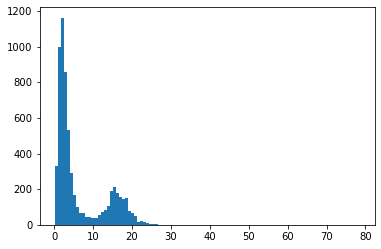

In [9]:
_ = plt.hist(max_fcs, bins=100)

In [10]:
badIndices = np.where(max_fcs > 30)[0]
badIndices

array([ 191, 5985])

## Initialize model

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [12]:
nrho = 4
nffg = 8
hidden_dim1 = 128
hidden_dim2 = 32

embeddings = {
    'rho_A': ([9], [0], nrho),
    'ffg_AA': ([9, 9], [0, 0, 1], nffg)
}

embedder = Embedder(embeddings, device)
model = Model(nrho+nffg, hidden_dim1=hidden_dim1, hidden_dim2=hidden_dim2)

In [13]:
baseName = 'AL_Al'
savePath = 'runs/{}_r_{}_f_{}_h1_{}_h2_{}_f_6352_unpin'.format(baseName, nrho, nffg, hidden_dim1, hidden_dim2)
writer = SummaryWriter(savePath)

In [14]:
f = lambda s: int(os.path.split(s)[-1].split('.')[0])
sorted(glob.glob(os.path.join(savePath, '*.model')), key=f)

['runs/AL_Al_r_4_f_8_h1_128_h2_32_f_6352_unpin/10.model',
 'runs/AL_Al_r_4_f_8_h1_128_h2_32_f_6352_unpin/20.model',
 'runs/AL_Al_r_4_f_8_h1_128_h2_32_f_6352_unpin/30.model',
 'runs/AL_Al_r_4_f_8_h1_128_h2_32_f_6352_unpin/40.model',
 'runs/AL_Al_r_4_f_8_h1_128_h2_32_f_6352_unpin/50.model',
 'runs/AL_Al_r_4_f_8_h1_128_h2_32_f_6352_unpin/60.model',
 'runs/AL_Al_r_4_f_8_h1_128_h2_32_f_6352_unpin/70.model',
 'runs/AL_Al_r_4_f_8_h1_128_h2_32_f_6352_unpin/80.model',
 'runs/AL_Al_r_4_f_8_h1_128_h2_32_f_6352_unpin/90.model',
 'runs/AL_Al_r_4_f_8_h1_128_h2_32_f_6352_unpin/100.model',
 'runs/AL_Al_r_4_f_8_h1_128_h2_32_f_6352_unpin/110.model',
 'runs/AL_Al_r_4_f_8_h1_128_h2_32_f_6352_unpin/120.model',
 'runs/AL_Al_r_4_f_8_h1_128_h2_32_f_6352_unpin/130.model',
 'runs/AL_Al_r_4_f_8_h1_128_h2_32_f_6352_unpin/140.model',
 'runs/AL_Al_r_4_f_8_h1_128_h2_32_f_6352_unpin/150.model',
 'runs/AL_Al_r_4_f_8_h1_128_h2_32_f_6352_unpin/160.model',
 'runs/AL_Al_r_4_f_8_h1_128_h2_32_f_6352_unpin/170.model',
 'runs

In [15]:
ii = 910
embedder.load_state_dict(torch.load(os.path.join(savePath, '{}.embedder'.format(ii))))
embedder.eval()

model.load_state_dict(torch.load(os.path.join(savePath, '{}.model'.format(ii))))
model.eval()

Model(
  (linear1): Linear(in_features=12, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=128, bias=True)
  (linear3): Linear(in_features=128, out_features=32, bias=True)
  (linear4): Linear(in_features=32, out_features=1, bias=True)
  (bnorm1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (splus): Softplus(beta=1, threshold=20)
  (celu): CELU(alpha=1.0)
)

In [16]:
model.to(device)
embedder.to(device)

Embedder()

In [17]:
model

Model(
  (linear1): Linear(in_features=12, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=128, bias=True)
  (linear3): Linear(in_features=128, out_features=32, bias=True)
  (linear4): Linear(in_features=32, out_features=1, bias=True)
  (bnorm1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (splus): Softplus(beta=1, threshold=20)
  (celu): CELU(alpha=1.0)
)

In [18]:
loss_fxn = nn.MSELoss()

# optimizer_embed = torch.optim.SGD(embedder.parameters(), lr=1e-5, momentum=0.9)
# optimizer_model = torch.optim.SGD(model.parameters(), lr=1e-5, momentum=0.9)

optimizer_embed = torch.optim.Adam(embedder.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-08)
optimizer_model = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-08)

lambda_embed = lambda epoch: 0.90**(epoch//10000)
lambda_model = lambda epoch: 0.75**(epoch//10000)

scheduler_embed =  torch.optim.lr_scheduler.MultiStepLR(optimizer_embed, milestones=[100000], gamma=0.1)
scheduler_model =  torch.optim.lr_scheduler.MultiStepLR(optimizer_model, milestones=[100000], gamma=0.1)

### Helper functions

In [19]:
# Define plotting functions

def plot_pred_vs_true(eng, fcs, all_true_eng, all_true_fcs):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
#     fig, ax = plt.subplots(figsize=(6, 6))

    # Energy errors figure
    xl, xh = min(all_true_eng), max(all_true_eng)

    rmse = np.sqrt(np.average((eng - all_true_eng)**2))
    ax[0].plot(all_true_eng, eng, 'o', markersize=1, label='RMSE: {:.3f} eV/atom'.format(rmse), alpha=1)
    ax[0].plot([xl, xh], [xl, xh], '--r')

    lgnd = ax[0].legend(loc = 'upper left')
    lgnd.legendHandles[0]._legmarker.set_markersize(6)
    lgnd.legendHandles[0]._legmarker.set_alpha(1)

    ax[0].set_xlim([xl, xh])
    ax[0].set_ylim([xl, xh])

    ax[0].set_aspect('equal')

    ax[0].set_xlabel('True', fontsize=12)
    ax[0].set_ylabel("Predicted", fontsize=12)

    _ = ax[0].set_title('Energies')
    
    # Forces errors figure
    xl, xh = min(all_true_fcs), max(all_true_fcs)

    rmse = np.sqrt(np.average((fcs - all_true_fcs)**2))
    ax[1].plot(all_true_fcs, fcs, 'o', markersize=1, label='RMSE: {:.3f} eV/A'.format(rmse), alpha=0.05)
    ax[1].plot([xl, xh], [xl, xh], '--r')

    lgnd = ax[1].legend(loc = 'upper left')
    lgnd.legendHandles[0]._legmarker.set_markersize(6)
    lgnd.legendHandles[0]._legmarker.set_alpha(1)

    ax[1].set_xlim([xl, xh])
    ax[1].set_ylim([xl, xh])

    ax[1].set_aspect('equal')

    ax[1].set_xlabel('True', fontsize=12)
    ax[1].set_ylabel("Predicted", fontsize=12)

    _ = ax[1].set_title('Forces')
    
#     # Forces errors figure
#     xl, xh = min(all_true_fcs), max(all_true_fcs)

#     rmse = np.sqrt(np.average((fcs - all_true_fcs)**2))
#     ax.plot(all_true_fcs, fcs, 'o', markersize=1, label='RMSE: {:.3f} eV/A'.format(rmse), alpha=0.05)
#     ax.plot([xl, xh], [xl, xh], '--r')

#     lgnd = ax.legend(loc = 'upper left')
#     lgnd.legendHandles[0]._legmarker.set_markersize(6)
#     lgnd.legendHandles[0]._legmarker.set_alpha(1)

#     ax.set_xlim([xl, xh])
#     ax.set_ylim([xl, xh])

#     ax.set_aspect('equal')

#     ax.set_xlabel('True', fontsize=12)
#     ax.set_ylabel("Predicted", fontsize=12)

#     _ = ax.set_title('Forces')
#     plt.tight_layout()
    
    return fig

# @@ Cell 12
def plot_splines(splitParams, names):
    numRows = int(max(1, np.ceil(len(splitParams)/3)))

    fig, axes = plt.subplots(numRows, 3, figsize=(12, 4*numRows))

    for i, (spline, name) in enumerate(zip(splitParams, names)):
        y, bc = spline[:-2], spline[-2:]

    #     if 'g' in compNames[i]:
    #         x = np.linspace(-1, 1, len(y))
    #     else:
    #         x = np.linspace(2.5, 7.0, len(y))

        x = np.linspace(2.5, 7.0, len(y))
        
        cs = CubicSpline(x, y, bc_type=((1, bc[0]), (1, bc[1])))
        cs = CubicSpline(x, y, bc_type='natural')

        plotX = np.linspace(x[0]-.1, x[-1]+.1, 100)
        plotY = cs(plotX)
        
        row = i//3
        col = i%3

        if numRows > 1:
            ax = axes[row][col]
        else:
            ax = axes[col]

        ax.plot(x, y, 'o')
        ax.plot(plotX, plotY)
        ax.set_title(name)
    
    return fig

## Begin training

In [ ]:
ns = len(dataset)

epochs = 1000000
batch_size = 1024

indices = np.arange(ns)
start = time.time()
for t in range(epochs):
    # Build random batches
    random.shuffle(indices)
    batches = np.array_split(indices, ns//batch_size)
    
    epoch_eng = []
    epoch_fcs = []
    epoch_true_eng = []
    epoch_true_fcs = []

    # Evaluate all batches
    epoch_loss = 0
    for batch in batches:
        batch = batch.tolist()
        
        for bi in badIndices:
            if bi in batch:
                batch.remove(bi)

        if dataset.refIdx not in batch:
            batch.append(dataset.refIdx)

#         svs_eng = {
#             'rho_A': torch.Tensor(np.vstack([dataset.svs['rho_A']['Al']['energy'][i] for i in batch])).to(device),
#             'ffg_AA': torch.Tensor(np.vstack([dataset.svs['ffg_AA']['Al']['energy'][i] for i in batch])).to(device),
#         }

        svs_fcs = {
            'rho_A': torch.Tensor(np.concatenate([dataset.svs['rho_A']['Al']['forces'][i] for i in batch])).to(device),
            'ffg_AA': torch.Tensor(np.concatenate([dataset.svs['ffg_AA']['Al']['forces'][i] for i in batch])).to(device),
        }

#         all_true_eng = torch.Tensor([dataset.all_true_eng[i] for i in batch]).to(device)
        all_true_fcs = torch.Tensor(np.concatenate([dataset.all_true_fcs[i] for i in batch])).to(device)
        splits = [dataset.natoms[i] for i in batch]

        # Compute loss
#         descriptors_eng, descriptors_fcs = embedder.embed(svs_eng, svs_fcs)
        descriptors_fcs = embedder.embed(svs_fcs)
#         eng, fcs = model(descriptors_eng, descriptors_fcs, splits)
        fcs = model(descriptors_fcs, splits)
#         eng = eng - eng[batch.index(dataset.refIdx)]
        
#         epoch_eng.append(np.array(eng.cpu().detach()))
        epoch_fcs.append(np.array(fcs.cpu().detach()))
#         epoch_true_eng.append(np.array(all_true_eng.cpu().detach()))
        epoch_true_fcs.append(np.array(all_true_fcs.cpu().detach()))

#         loss_eng = loss_fxn(eng, all_true_eng)*10
        loss_fcs = loss_fxn(fcs, all_true_fcs)

#         loss = loss_eng + loss_fcs
        loss = loss_fcs

        # Backpropogate errors
        optimizer_model.zero_grad()
        optimizer_embed.zero_grad()
        loss.backward(retain_graph=True)
        optimizer_embed.step()
        optimizer_model.step()
        
        scheduler_embed.step()
        scheduler_model.step()

        batch_loss = loss.detach().item()
        epoch_loss += batch_loss*(len(batch)/ns)  # weighted average
        
#         recheck_loss = np.average(
#             (np.array(fcs.cpu().detach()) - np.array(all_true_fcs.cpu().detach()))**2
#         )
        
#         print("Batch loss: {:.6f} -- {:.2f} (s)".format(batch_loss, recheck_loss))
        
    # Print status
    print("Epoch {} loss (avg. batch loss): {:.6f} -- {:.2f} (s)".format(t, epoch_loss, time.time()-start))
#     break
    model.steps += 1
    embedder.steps += 1
    
    writer.add_scalar('Training loss', epoch_loss, model.steps+1)

    # Log results and do garbage collection
    if (t+1)%10 == 0:
#         torch.save(embedder.state_dict(), os.path.join(savePath, '{}.embedder'.format(t+1)))
#         torch.save(model.state_dict(), os.path.join(savePath, '{}.model'.format(t+1)))
        
        checkpoint_model = { 
            'model': model,
            'optimizer': optimizer_model.state_dict()
        }

        checkpoint_embed = { 
            'model': embedder,
            'optimizer': optimizer_embed.state_dict()
        }

        torch.save(checkpoint_model, os.path.join(savePath, '{}.model'.format(t+1)))
        torch.save(checkpoint_embed, os.path.join(savePath, '{}.embed'.format(t+1)))
        
#         eng_np = np.array(eng.cpu().detach())
#         fcs_np = np.array(fcs.cpu().detach())
#         true_eng_np = np.array(all_true_eng.cpu().detach())
#         true_fcs_np = np.array(all_true_fcs.cpu().detach())
        
#         eng_np = np.concatenate(epoch_eng)
        fcs_np = np.concatenate(epoch_fcs)
#         true_eng_np = np.concatenate(epoch_true_eng)
        true_fcs_np = np.concatenate(epoch_true_fcs)
        eng_np = np.zeros(1)
        true_eng_np = np.zeros(1)
        
        writer.add_figure(
            'Predictions vs. True',
            plot_pred_vs_true(
                eng_np,
                fcs_np,
                true_eng_np,
                true_fcs_np
            ),
            global_step=model.steps
        )
        
        splitParams = []
        names = []
        for k in embedder.embeddings:
            for d in range(embedder.embeddings[k][2]):
                for i in range(len(embedder.embeddings[k][0])):
                    s, n = embedder._fill(k, d, i)
                    splitParams.append(np.array(s.cpu().detach()))
                    names.append(n)
        
        writer.add_figure(
            'Splines',
            plot_splines(splitParams, names),
            global_step=embedder.steps
        )
        
#         del descriptors_eng
        del descriptors_fcs
        
#         del eng
        del fcs
        
#         del loss_eng
        del loss_fcs
        del loss
        
        del eng_np
        del fcs_np
        del true_eng_np
        del true_fcs_np
        
        del splitParams
        
        gc.collect()

Epoch 0 loss (avg. batch loss): 0.325964 -- 51.48 (s)
Epoch 1 loss (avg. batch loss): 0.325691 -- 104.26 (s)
Epoch 2 loss (avg. batch loss): 0.325243 -- 165.53 (s)
Epoch 3 loss (avg. batch loss): 0.324901 -- 224.76 (s)
Epoch 4 loss (avg. batch loss): 0.324487 -- 281.81 (s)
Epoch 5 loss (avg. batch loss): 0.324177 -- 340.87 (s)
Epoch 6 loss (avg. batch loss): 0.323710 -- 401.67 (s)
Epoch 7 loss (avg. batch loss): 0.323371 -- 460.21 (s)
Epoch 8 loss (avg. batch loss): 0.322793 -- 520.67 (s)
Epoch 9 loss (avg. batch loss): 0.322554 -- 576.08 (s)


/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


Epoch 10 loss (avg. batch loss): 0.322231 -- 641.07 (s)
Epoch 11 loss (avg. batch loss): 0.321692 -- 700.87 (s)
Epoch 12 loss (avg. batch loss): 0.321470 -- 759.53 (s)
Epoch 13 loss (avg. batch loss): 0.320862 -- 819.50 (s)
Epoch 14 loss (avg. batch loss): 0.320431 -- 878.46 (s)
Epoch 15 loss (avg. batch loss): 0.320067 -- 940.65 (s)
Epoch 16 loss (avg. batch loss): 0.319625 -- 1000.80 (s)
Epoch 17 loss (avg. batch loss): 0.319369 -- 1062.10 (s)
Epoch 18 loss (avg. batch loss): 0.318987 -- 1121.51 (s)
Epoch 19 loss (avg. batch loss): 0.318401 -- 1180.56 (s)


/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


Epoch 20 loss (avg. batch loss): 0.317995 -- 1245.84 (s)
Epoch 21 loss (avg. batch loss): 0.317727 -- 1305.35 (s)
Epoch 22 loss (avg. batch loss): 0.317224 -- 1362.14 (s)
Epoch 23 loss (avg. batch loss): 0.316849 -- 1422.54 (s)
Epoch 24 loss (avg. batch loss): 0.316805 -- 1484.06 (s)
Epoch 25 loss (avg. batch loss): 0.316442 -- 1543.04 (s)
Epoch 26 loss (avg. batch loss): 0.316125 -- 1603.43 (s)
Epoch 27 loss (avg. batch loss): 0.315435 -- 1659.98 (s)
Epoch 28 loss (avg. batch loss): 0.315089 -- 1719.01 (s)
Epoch 29 loss (avg. batch loss): 0.314840 -- 1778.03 (s)


/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


Epoch 30 loss (avg. batch loss): 0.314264 -- 1841.29 (s)
Epoch 31 loss (avg. batch loss): 0.313893 -- 1897.66 (s)
Epoch 32 loss (avg. batch loss): 0.313431 -- 1954.97 (s)
Epoch 33 loss (avg. batch loss): 0.313153 -- 2014.40 (s)
Epoch 34 loss (avg. batch loss): 0.312638 -- 2073.23 (s)
Epoch 35 loss (avg. batch loss): 0.312347 -- 2131.52 (s)
Epoch 36 loss (avg. batch loss): 0.312047 -- 2193.75 (s)
Epoch 37 loss (avg. batch loss): 0.311505 -- 2253.18 (s)
Epoch 38 loss (avg. batch loss): 0.311086 -- 2306.38 (s)
Epoch 39 loss (avg. batch loss): 0.310813 -- 2362.09 (s)


/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


Epoch 40 loss (avg. batch loss): 0.310486 -- 2430.66 (s)
Epoch 41 loss (avg. batch loss): 0.310214 -- 2488.74 (s)
Epoch 42 loss (avg. batch loss): 0.309913 -- 2546.16 (s)
Epoch 43 loss (avg. batch loss): 0.309259 -- 2604.21 (s)
Epoch 44 loss (avg. batch loss): 0.308843 -- 2662.14 (s)
Epoch 45 loss (avg. batch loss): 0.308376 -- 2712.75 (s)
Epoch 46 loss (avg. batch loss): 0.308227 -- 2763.57 (s)
Epoch 47 loss (avg. batch loss): 0.308476 -- 2819.09 (s)
Epoch 48 loss (avg. batch loss): 0.308020 -- 2877.12 (s)
Epoch 49 loss (avg. batch loss): 0.307416 -- 2935.16 (s)


/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


Epoch 50 loss (avg. batch loss): 0.307055 -- 2997.13 (s)
Epoch 51 loss (avg. batch loss): 0.306536 -- 3054.53 (s)
Epoch 52 loss (avg. batch loss): 0.306227 -- 3106.72 (s)
Epoch 53 loss (avg. batch loss): 0.305712 -- 3165.72 (s)
Epoch 54 loss (avg. batch loss): 0.305575 -- 3224.95 (s)
Epoch 55 loss (avg. batch loss): 0.305290 -- 3282.90 (s)
Epoch 56 loss (avg. batch loss): 0.305057 -- 3338.49 (s)
Epoch 57 loss (avg. batch loss): 0.304148 -- 3397.85 (s)
Epoch 58 loss (avg. batch loss): 0.304052 -- 3456.29 (s)
Epoch 59 loss (avg. batch loss): 0.303556 -- 3514.40 (s)


/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


Epoch 60 loss (avg. batch loss): 0.302993 -- 3577.63 (s)
Epoch 61 loss (avg. batch loss): 0.302745 -- 3629.43 (s)
Epoch 62 loss (avg. batch loss): 0.302455 -- 3684.13 (s)
Epoch 63 loss (avg. batch loss): 0.302205 -- 3743.90 (s)
Epoch 64 loss (avg. batch loss): 0.301839 -- 3802.17 (s)
Epoch 65 loss (avg. batch loss): 0.301521 -- 3862.92 (s)
Epoch 66 loss (avg. batch loss): 0.301208 -- 3920.61 (s)
Epoch 67 loss (avg. batch loss): 0.300942 -- 3971.78 (s)
Epoch 68 loss (avg. batch loss): 0.300581 -- 4016.96 (s)
Epoch 69 loss (avg. batch loss): 0.300057 -- 4062.76 (s)


/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


Epoch 70 loss (avg. batch loss): 0.299761 -- 4121.67 (s)
Epoch 71 loss (avg. batch loss): 0.299682 -- 4176.78 (s)
Epoch 72 loss (avg. batch loss): 0.299407 -- 4233.18 (s)
Epoch 73 loss (avg. batch loss): 0.298937 -- 4292.57 (s)
Epoch 74 loss (avg. batch loss): 0.298725 -- 4350.70 (s)
Epoch 75 loss (avg. batch loss): 0.298737 -- 4409.24 (s)
Epoch 76 loss (avg. batch loss): 0.298071 -- 4469.83 (s)
Epoch 77 loss (avg. batch loss): 0.297518 -- 4527.44 (s)
Epoch 78 loss (avg. batch loss): 0.297331 -- 4580.80 (s)
Epoch 79 loss (avg. batch loss): 0.297069 -- 4625.24 (s)


/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


Epoch 80 loss (avg. batch loss): 0.296999 -- 4672.99 (s)
Epoch 81 loss (avg. batch loss): 0.296639 -- 4712.94 (s)
Epoch 82 loss (avg. batch loss): 0.296055 -- 4754.32 (s)
Epoch 83 loss (avg. batch loss): 0.295558 -- 4793.93 (s)
Epoch 84 loss (avg. batch loss): 0.295273 -- 4834.00 (s)
Epoch 85 loss (avg. batch loss): 0.294878 -- 4873.13 (s)
Epoch 86 loss (avg. batch loss): 0.294661 -- 4912.84 (s)
Epoch 87 loss (avg. batch loss): 0.294459 -- 4952.63 (s)
Epoch 88 loss (avg. batch loss): 0.294052 -- 4993.43 (s)
Epoch 89 loss (avg. batch loss): 0.293978 -- 5032.01 (s)


/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


Epoch 90 loss (avg. batch loss): 0.293496 -- 5079.58 (s)
Epoch 91 loss (avg. batch loss): 0.293471 -- 5121.95 (s)
Epoch 92 loss (avg. batch loss): 0.292883 -- 5163.04 (s)
Epoch 93 loss (avg. batch loss): 0.292570 -- 5202.81 (s)
Epoch 94 loss (avg. batch loss): 0.292293 -- 5245.19 (s)
Epoch 95 loss (avg. batch loss): 0.292212 -- 5287.31 (s)
Epoch 96 loss (avg. batch loss): 0.291918 -- 5329.51 (s)
Epoch 97 loss (avg. batch loss): 0.291393 -- 5371.55 (s)
Epoch 98 loss (avg. batch loss): 0.291310 -- 5413.61 (s)
Epoch 99 loss (avg. batch loss): 0.291173 -- 5454.07 (s)


/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


Epoch 100 loss (avg. batch loss): 0.291177 -- 5502.04 (s)
Epoch 101 loss (avg. batch loss): 0.290586 -- 5540.91 (s)
Epoch 102 loss (avg. batch loss): 0.290019 -- 5581.57 (s)
Epoch 103 loss (avg. batch loss): 0.289717 -- 5622.77 (s)
Epoch 104 loss (avg. batch loss): 0.289514 -- 5664.32 (s)
Epoch 105 loss (avg. batch loss): 0.289234 -- 5702.13 (s)
Epoch 106 loss (avg. batch loss): 0.289359 -- 5741.58 (s)
Epoch 107 loss (avg. batch loss): 0.288969 -- 5781.86 (s)
Epoch 108 loss (avg. batch loss): 0.288971 -- 5820.00 (s)
Epoch 109 loss (avg. batch loss): 0.288110 -- 5858.22 (s)


/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


Epoch 110 loss (avg. batch loss): 0.287992 -- 5903.74 (s)
Epoch 111 loss (avg. batch loss): 0.287852 -- 5942.98 (s)
Epoch 112 loss (avg. batch loss): 0.287389 -- 5980.66 (s)
Epoch 113 loss (avg. batch loss): 0.286906 -- 6019.22 (s)
Epoch 114 loss (avg. batch loss): 0.287151 -- 6058.22 (s)
Epoch 115 loss (avg. batch loss): 0.286855 -- 6098.55 (s)
Epoch 116 loss (avg. batch loss): 0.286490 -- 6139.11 (s)
Epoch 117 loss (avg. batch loss): 0.286342 -- 6178.09 (s)
Epoch 118 loss (avg. batch loss): 0.286815 -- 6219.24 (s)
Epoch 119 loss (avg. batch loss): 0.287059 -- 6260.94 (s)


/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


Epoch 120 loss (avg. batch loss): 0.286101 -- 6306.09 (s)
Epoch 121 loss (avg. batch loss): 0.285459 -- 6344.97 (s)
Epoch 122 loss (avg. batch loss): 0.285356 -- 6385.36 (s)
Epoch 123 loss (avg. batch loss): 0.284791 -- 6426.06 (s)
Epoch 124 loss (avg. batch loss): 0.284316 -- 6466.21 (s)
Epoch 125 loss (avg. batch loss): 0.283846 -- 6506.01 (s)
Epoch 126 loss (avg. batch loss): 0.284115 -- 6546.61 (s)
Epoch 127 loss (avg. batch loss): 0.284209 -- 6587.40 (s)
Epoch 128 loss (avg. batch loss): 0.283813 -- 6626.86 (s)
Epoch 129 loss (avg. batch loss): 0.283256 -- 6667.25 (s)


/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


Epoch 130 loss (avg. batch loss): 0.283122 -- 6713.01 (s)
Epoch 131 loss (avg. batch loss): 0.282438 -- 6753.57 (s)
Epoch 132 loss (avg. batch loss): 0.282619 -- 6793.15 (s)
Epoch 133 loss (avg. batch loss): 0.282749 -- 6833.20 (s)
Epoch 134 loss (avg. batch loss): 0.282255 -- 6869.50 (s)
Epoch 135 loss (avg. batch loss): 0.281860 -- 6908.43 (s)
Epoch 136 loss (avg. batch loss): 0.281641 -- 6948.07 (s)
Epoch 137 loss (avg. batch loss): 0.281026 -- 6987.77 (s)
Epoch 138 loss (avg. batch loss): 0.280851 -- 7029.19 (s)
Epoch 139 loss (avg. batch loss): 0.280902 -- 7067.82 (s)


/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


Epoch 140 loss (avg. batch loss): 0.280307 -- 7113.76 (s)
Epoch 141 loss (avg. batch loss): 0.280660 -- 7153.09 (s)
Epoch 142 loss (avg. batch loss): 0.279686 -- 7192.79 (s)
Epoch 143 loss (avg. batch loss): 0.279835 -- 7234.21 (s)
Epoch 144 loss (avg. batch loss): 0.279413 -- 7274.34 (s)
Epoch 145 loss (avg. batch loss): 0.279450 -- 7313.63 (s)
Epoch 146 loss (avg. batch loss): 0.279135 -- 7353.69 (s)
Epoch 147 loss (avg. batch loss): 0.278487 -- 7392.74 (s)
Epoch 148 loss (avg. batch loss): 0.278719 -- 7432.68 (s)
Epoch 149 loss (avg. batch loss): 0.279058 -- 7473.23 (s)


/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


Epoch 150 loss (avg. batch loss): 0.279616 -- 7522.36 (s)
Epoch 151 loss (avg. batch loss): 0.279038 -- 7560.78 (s)
Epoch 152 loss (avg. batch loss): 0.277717 -- 7600.72 (s)
Epoch 153 loss (avg. batch loss): 0.277253 -- 7638.70 (s)
Epoch 154 loss (avg. batch loss): 0.277792 -- 7677.18 (s)
Epoch 155 loss (avg. batch loss): 0.277120 -- 7716.86 (s)
Epoch 156 loss (avg. batch loss): 0.277212 -- 7756.76 (s)
Epoch 157 loss (avg. batch loss): 0.277509 -- 7797.79 (s)
Epoch 158 loss (avg. batch loss): 0.277899 -- 7835.55 (s)
Epoch 159 loss (avg. batch loss): 0.278990 -- 7874.89 (s)


/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


Epoch 160 loss (avg. batch loss): 0.277021 -- 7922.47 (s)
Epoch 161 loss (avg. batch loss): 0.275908 -- 7963.31 (s)
Epoch 162 loss (avg. batch loss): 0.276150 -- 8001.94 (s)
Epoch 163 loss (avg. batch loss): 0.275665 -- 8039.75 (s)
Epoch 164 loss (avg. batch loss): 0.275993 -- 8079.27 (s)
Epoch 165 loss (avg. batch loss): 0.277434 -- 8118.39 (s)
Epoch 166 loss (avg. batch loss): 0.274965 -- 8157.69 (s)
Epoch 167 loss (avg. batch loss): 0.274094 -- 8198.18 (s)
Epoch 168 loss (avg. batch loss): 0.274671 -- 8241.64 (s)
Epoch 169 loss (avg. batch loss): 0.273966 -- 8283.05 (s)


/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


Epoch 170 loss (avg. batch loss): 0.274159 -- 8331.09 (s)
Epoch 171 loss (avg. batch loss): 0.273247 -- 8372.04 (s)
Epoch 172 loss (avg. batch loss): 0.272919 -- 8413.71 (s)
Epoch 173 loss (avg. batch loss): 0.272861 -- 8455.07 (s)
Epoch 174 loss (avg. batch loss): 0.273380 -- 8495.20 (s)
Epoch 175 loss (avg. batch loss): 0.272945 -- 8536.13 (s)
Epoch 176 loss (avg. batch loss): 0.273622 -- 8578.97 (s)
Epoch 177 loss (avg. batch loss): 0.272868 -- 8621.61 (s)
Epoch 178 loss (avg. batch loss): 0.272812 -- 8663.69 (s)
Epoch 179 loss (avg. batch loss): 0.272848 -- 8706.90 (s)


/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


Epoch 180 loss (avg. batch loss): 0.271922 -- 8754.69 (s)
Epoch 181 loss (avg. batch loss): 0.271677 -- 8796.40 (s)
Epoch 182 loss (avg. batch loss): 0.271873 -- 8837.11 (s)
Epoch 183 loss (avg. batch loss): 0.270663 -- 8878.10 (s)
Epoch 184 loss (avg. batch loss): 0.270564 -- 8918.93 (s)
Epoch 185 loss (avg. batch loss): 0.270811 -- 8961.82 (s)
Epoch 186 loss (avg. batch loss): 0.271600 -- 9003.51 (s)
Epoch 187 loss (avg. batch loss): 0.270605 -- 9045.31 (s)
Epoch 188 loss (avg. batch loss): 0.270206 -- 9088.21 (s)
Epoch 189 loss (avg. batch loss): 0.270134 -- 9130.25 (s)


/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


Epoch 190 loss (avg. batch loss): 0.269988 -- 9178.93 (s)
Epoch 191 loss (avg. batch loss): 0.269910 -- 9221.06 (s)
Epoch 192 loss (avg. batch loss): 0.271634 -- 9264.95 (s)
Epoch 193 loss (avg. batch loss): 0.273998 -- 9306.26 (s)
Epoch 194 loss (avg. batch loss): 0.272000 -- 9347.59 (s)
Epoch 195 loss (avg. batch loss): 0.272449 -- 9390.23 (s)
Epoch 196 loss (avg. batch loss): 0.269915 -- 9433.55 (s)
Epoch 197 loss (avg. batch loss): 0.270225 -- 9477.26 (s)
Epoch 198 loss (avg. batch loss): 0.269493 -- 9520.35 (s)
Epoch 199 loss (avg. batch loss): 0.269202 -- 9563.26 (s)


/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


Epoch 200 loss (avg. batch loss): 0.269461 -- 9609.12 (s)
Epoch 201 loss (avg. batch loss): 0.272229 -- 9647.61 (s)
Epoch 202 loss (avg. batch loss): 0.270159 -- 9689.54 (s)
Epoch 203 loss (avg. batch loss): 0.270352 -- 9731.84 (s)
Epoch 204 loss (avg. batch loss): 0.269945 -- 9772.23 (s)
Epoch 205 loss (avg. batch loss): 0.270841 -- 9812.83 (s)
Epoch 206 loss (avg. batch loss): 0.272596 -- 9855.33 (s)
Epoch 207 loss (avg. batch loss): 0.269406 -- 9896.23 (s)
Epoch 208 loss (avg. batch loss): 0.267712 -- 9936.30 (s)
Epoch 209 loss (avg. batch loss): 0.266975 -- 9977.72 (s)


/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


Epoch 210 loss (avg. batch loss): 0.266135 -- 10027.67 (s)
Epoch 211 loss (avg. batch loss): 0.265900 -- 10068.80 (s)
Epoch 212 loss (avg. batch loss): 0.265721 -- 10109.40 (s)
Epoch 213 loss (avg. batch loss): 0.265438 -- 10151.30 (s)
Epoch 214 loss (avg. batch loss): 0.265402 -- 10192.98 (s)
Epoch 215 loss (avg. batch loss): 0.266800 -- 10233.41 (s)
Epoch 216 loss (avg. batch loss): 0.265605 -- 10273.39 (s)
Epoch 217 loss (avg. batch loss): 0.265057 -- 10312.88 (s)
Epoch 218 loss (avg. batch loss): 0.264444 -- 10350.17 (s)
Epoch 219 loss (avg. batch loss): 0.264811 -- 10388.80 (s)


/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


Epoch 220 loss (avg. batch loss): 0.264295 -- 10435.50 (s)
Epoch 221 loss (avg. batch loss): 0.264224 -- 10472.13 (s)
Epoch 222 loss (avg. batch loss): 0.264130 -- 10509.57 (s)
Epoch 223 loss (avg. batch loss): 0.265331 -- 10547.91 (s)
Epoch 224 loss (avg. batch loss): 0.268832 -- 10588.03 (s)
Epoch 225 loss (avg. batch loss): 0.265615 -- 10624.46 (s)
Epoch 226 loss (avg. batch loss): 0.263745 -- 10660.95 (s)
Epoch 227 loss (avg. batch loss): 0.264374 -- 10700.67 (s)
Epoch 228 loss (avg. batch loss): 0.265145 -- 10733.24 (s)
Epoch 229 loss (avg. batch loss): 0.265947 -- 10764.57 (s)


/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


Epoch 230 loss (avg. batch loss): 0.265886 -- 10805.52 (s)
Epoch 231 loss (avg. batch loss): 0.265304 -- 10836.43 (s)
Epoch 232 loss (avg. batch loss): 0.264308 -- 10868.10 (s)
Epoch 233 loss (avg. batch loss): 0.263819 -- 10899.51 (s)
Epoch 234 loss (avg. batch loss): 0.263273 -- 10931.40 (s)
Epoch 235 loss (avg. batch loss): 0.262337 -- 10968.21 (s)
Epoch 236 loss (avg. batch loss): 0.262997 -- 11006.63 (s)
Epoch 237 loss (avg. batch loss): 0.262622 -- 11046.38 (s)
Epoch 238 loss (avg. batch loss): 0.261714 -- 11086.79 (s)
Epoch 239 loss (avg. batch loss): 0.261835 -- 11124.57 (s)


/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


Epoch 240 loss (avg. batch loss): 0.261520 -- 11169.29 (s)
Epoch 241 loss (avg. batch loss): 0.260881 -- 11207.21 (s)
Epoch 242 loss (avg. batch loss): 0.260734 -- 11242.88 (s)
Epoch 243 loss (avg. batch loss): 0.260741 -- 11278.52 (s)
Epoch 244 loss (avg. batch loss): 0.260459 -- 11316.52 (s)
Epoch 245 loss (avg. batch loss): 0.260262 -- 11356.03 (s)
Epoch 246 loss (avg. batch loss): 0.261850 -- 11393.17 (s)
Epoch 247 loss (avg. batch loss): 0.264263 -- 11428.34 (s)
Epoch 248 loss (avg. batch loss): 0.262261 -- 11464.44 (s)
Epoch 249 loss (avg. batch loss): 0.262465 -- 11500.24 (s)


/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


Epoch 250 loss (avg. batch loss): 0.259869 -- 11546.98 (s)
Epoch 251 loss (avg. batch loss): 0.259059 -- 11587.55 (s)
Epoch 252 loss (avg. batch loss): 0.258875 -- 11630.06 (s)
Epoch 253 loss (avg. batch loss): 0.259651 -- 11671.90 (s)
Epoch 254 loss (avg. batch loss): 0.259013 -- 11715.12 (s)
Epoch 255 loss (avg. batch loss): 0.259519 -- 11757.87 (s)
Epoch 256 loss (avg. batch loss): 0.259536 -- 11800.83 (s)
Epoch 257 loss (avg. batch loss): 0.259850 -- 11843.52 (s)
Epoch 258 loss (avg. batch loss): 0.258672 -- 11880.81 (s)
Epoch 259 loss (avg. batch loss): 0.257635 -- 11914.70 (s)


/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


Epoch 260 loss (avg. batch loss): 0.257474 -- 11962.09 (s)
Epoch 261 loss (avg. batch loss): 0.257657 -- 11997.49 (s)
Epoch 262 loss (avg. batch loss): 0.258615 -- 12036.81 (s)
Epoch 263 loss (avg. batch loss): 0.257642 -- 12073.52 (s)
Epoch 264 loss (avg. batch loss): 0.259073 -- 12109.37 (s)
Epoch 265 loss (avg. batch loss): 0.259600 -- 12144.10 (s)
Epoch 266 loss (avg. batch loss): 0.258238 -- 12180.74 (s)
Epoch 267 loss (avg. batch loss): 0.257518 -- 12217.82 (s)
Epoch 268 loss (avg. batch loss): 0.256175 -- 12255.52 (s)
Epoch 269 loss (avg. batch loss): 0.256710 -- 12292.02 (s)


/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


Epoch 270 loss (avg. batch loss): 0.256813 -- 12336.77 (s)
Epoch 271 loss (avg. batch loss): 0.256801 -- 12374.51 (s)
Epoch 272 loss (avg. batch loss): 0.256063 -- 12413.09 (s)
Epoch 273 loss (avg. batch loss): 0.257167 -- 12452.76 (s)
Epoch 274 loss (avg. batch loss): 0.257731 -- 12491.30 (s)
Epoch 275 loss (avg. batch loss): 0.261666 -- 12527.38 (s)
Epoch 276 loss (avg. batch loss): 0.257841 -- 12561.12 (s)
Epoch 277 loss (avg. batch loss): 0.256488 -- 12598.35 (s)
Epoch 278 loss (avg. batch loss): 0.255396 -- 12636.71 (s)
Epoch 279 loss (avg. batch loss): 0.255219 -- 12675.41 (s)


/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


Epoch 280 loss (avg. batch loss): 0.255250 -- 12722.66 (s)
Epoch 281 loss (avg. batch loss): 0.257314 -- 12760.75 (s)
Epoch 282 loss (avg. batch loss): 0.256073 -- 12800.94 (s)
Epoch 283 loss (avg. batch loss): 0.255709 -- 12840.00 (s)
Epoch 284 loss (avg. batch loss): 0.254463 -- 12878.69 (s)
Epoch 285 loss (avg. batch loss): 0.254514 -- 12918.10 (s)
Epoch 286 loss (avg. batch loss): 0.254480 -- 12958.61 (s)
Epoch 287 loss (avg. batch loss): 0.256419 -- 12995.48 (s)
Epoch 288 loss (avg. batch loss): 0.255647 -- 13033.07 (s)
Epoch 289 loss (avg. batch loss): 0.255201 -- 13069.95 (s)


/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


Epoch 290 loss (avg. batch loss): 0.254310 -- 13118.38 (s)
Epoch 291 loss (avg. batch loss): 0.255033 -- 13155.00 (s)
Epoch 292 loss (avg. batch loss): 0.254389 -- 13191.48 (s)
Epoch 293 loss (avg. batch loss): 0.253831 -- 13226.26 (s)
Epoch 294 loss (avg. batch loss): 0.254872 -- 13262.91 (s)
Epoch 295 loss (avg. batch loss): 0.252287 -- 13293.07 (s)
Epoch 296 loss (avg. batch loss): 0.252899 -- 13322.52 (s)
Epoch 297 loss (avg. batch loss): 0.254297 -- 13351.71 (s)
Epoch 298 loss (avg. batch loss): 0.253422 -- 13380.01 (s)
Epoch 299 loss (avg. batch loss): 0.253456 -- 13409.14 (s)


/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


Epoch 300 loss (avg. batch loss): 0.254226 -- 13446.22 (s)
Epoch 301 loss (avg. batch loss): 0.258713 -- 13475.53 (s)
Epoch 302 loss (avg. batch loss): 0.257750 -- 13509.73 (s)
Epoch 303 loss (avg. batch loss): 0.257408 -- 13546.31 (s)
Epoch 304 loss (avg. batch loss): 0.253978 -- 13582.68 (s)
Epoch 305 loss (avg. batch loss): 0.251644 -- 13618.93 (s)
Epoch 306 loss (avg. batch loss): 0.251545 -- 13659.04 (s)
Epoch 307 loss (avg. batch loss): 0.251169 -- 13695.85 (s)
Epoch 308 loss (avg. batch loss): 0.251218 -- 13733.41 (s)
Epoch 309 loss (avg. batch loss): 0.251987 -- 13769.89 (s)


/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


Epoch 310 loss (avg. batch loss): 0.252057 -- 13815.84 (s)
Epoch 311 loss (avg. batch loss): 0.252444 -- 13852.44 (s)
Epoch 312 loss (avg. batch loss): 0.251044 -- 13882.91 (s)
Epoch 313 loss (avg. batch loss): 0.251321 -- 13914.30 (s)
Epoch 314 loss (avg. batch loss): 0.251210 -- 13945.51 (s)
Epoch 315 loss (avg. batch loss): 0.251175 -- 13976.02 (s)
Epoch 316 loss (avg. batch loss): 0.249511 -- 14007.47 (s)
Epoch 317 loss (avg. batch loss): 0.249930 -- 14043.55 (s)
Epoch 318 loss (avg. batch loss): 0.249329 -- 14083.58 (s)
Epoch 319 loss (avg. batch loss): 0.249020 -- 14121.45 (s)


/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


Epoch 320 loss (avg. batch loss): 0.249782 -- 14168.36 (s)
Epoch 321 loss (avg. batch loss): 0.248962 -- 14205.89 (s)
Epoch 322 loss (avg. batch loss): 0.249977 -- 14242.77 (s)
Epoch 323 loss (avg. batch loss): 0.249240 -- 14279.53 (s)
Epoch 324 loss (avg. batch loss): 0.248641 -- 14318.05 (s)
Epoch 325 loss (avg. batch loss): 0.249735 -- 14355.84 (s)
Epoch 326 loss (avg. batch loss): 0.250532 -- 14392.86 (s)
Epoch 327 loss (avg. batch loss): 0.249748 -- 14429.77 (s)
Epoch 328 loss (avg. batch loss): 0.249718 -- 14465.99 (s)
Epoch 329 loss (avg. batch loss): 0.249714 -- 14502.10 (s)


/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


Epoch 330 loss (avg. batch loss): 0.249283 -- 14545.67 (s)
Epoch 331 loss (avg. batch loss): 0.248807 -- 14581.83 (s)
Epoch 332 loss (avg. batch loss): 0.249821 -- 14616.99 (s)
Epoch 333 loss (avg. batch loss): 0.248093 -- 14652.69 (s)
Epoch 334 loss (avg. batch loss): 0.247625 -- 14687.41 (s)
Epoch 335 loss (avg. batch loss): 0.248763 -- 14718.81 (s)
Epoch 336 loss (avg. batch loss): 0.247388 -- 14753.47 (s)
Epoch 337 loss (avg. batch loss): 0.247433 -- 14788.57 (s)
Epoch 338 loss (avg. batch loss): 0.248933 -- 14820.83 (s)
Epoch 339 loss (avg. batch loss): 0.247501 -- 14855.78 (s)


/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


Epoch 340 loss (avg. batch loss): 0.248131 -- 14901.71 (s)
Epoch 341 loss (avg. batch loss): 0.247514 -- 14935.49 (s)
Epoch 342 loss (avg. batch loss): 0.248851 -- 14970.97 (s)
Epoch 343 loss (avg. batch loss): 0.247503 -- 15007.48 (s)
Epoch 344 loss (avg. batch loss): 0.246772 -- 15042.11 (s)
Epoch 345 loss (avg. batch loss): 0.248010 -- 15076.68 (s)
Epoch 346 loss (avg. batch loss): 0.249329 -- 15111.56 (s)
Epoch 347 loss (avg. batch loss): 0.249041 -- 15148.31 (s)
Epoch 348 loss (avg. batch loss): 0.248240 -- 15182.89 (s)
Epoch 349 loss (avg. batch loss): 0.247671 -- 15217.80 (s)


/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


Epoch 350 loss (avg. batch loss): 0.247025 -- 15262.39 (s)
Epoch 351 loss (avg. batch loss): 0.246338 -- 15297.71 (s)
Epoch 352 loss (avg. batch loss): 0.246246 -- 15333.25 (s)
Epoch 353 loss (avg. batch loss): 0.245860 -- 15370.07 (s)
Epoch 354 loss (avg. batch loss): 0.246155 -- 15406.65 (s)
Epoch 355 loss (avg. batch loss): 0.245263 -- 15441.80 (s)
Epoch 356 loss (avg. batch loss): 0.244361 -- 15477.33 (s)
Epoch 357 loss (avg. batch loss): 0.245399 -- 15513.69 (s)
Epoch 358 loss (avg. batch loss): 0.246217 -- 15548.77 (s)
Epoch 359 loss (avg. batch loss): 0.245774 -- 15584.96 (s)


/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


Epoch 360 loss (avg. batch loss): 0.244566 -- 15632.12 (s)
Epoch 361 loss (avg. batch loss): 0.243969 -- 15668.49 (s)
Epoch 362 loss (avg. batch loss): 0.243583 -- 15704.12 (s)
Epoch 363 loss (avg. batch loss): 0.243724 -- 15739.24 (s)
Epoch 364 loss (avg. batch loss): 0.243374 -- 15775.16 (s)
Epoch 365 loss (avg. batch loss): 0.243432 -- 15809.05 (s)
Epoch 366 loss (avg. batch loss): 0.244014 -- 15843.94 (s)
Epoch 367 loss (avg. batch loss): 0.244998 -- 15880.73 (s)
Epoch 368 loss (avg. batch loss): 0.245131 -- 15917.63 (s)
Epoch 369 loss (avg. batch loss): 0.245619 -- 15953.53 (s)


/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


Epoch 370 loss (avg. batch loss): 0.243932 -- 15997.86 (s)
Epoch 371 loss (avg. batch loss): 0.243077 -- 16036.06 (s)
Epoch 372 loss (avg. batch loss): 0.242936 -- 16073.15 (s)
Epoch 373 loss (avg. batch loss): 0.245194 -- 16108.90 (s)
Epoch 374 loss (avg. batch loss): 0.244291 -- 16145.13 (s)
Epoch 375 loss (avg. batch loss): 0.243646 -- 16182.67 (s)
Epoch 376 loss (avg. batch loss): 0.243922 -- 16220.67 (s)
Epoch 377 loss (avg. batch loss): 0.242201 -- 16257.12 (s)
Epoch 378 loss (avg. batch loss): 0.243048 -- 16293.56 (s)
Epoch 379 loss (avg. batch loss): 0.242546 -- 16329.13 (s)


/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


Epoch 380 loss (avg. batch loss): 0.243352 -- 16374.93 (s)
Epoch 381 loss (avg. batch loss): 0.241525 -- 16410.49 (s)
Epoch 382 loss (avg. batch loss): 0.241361 -- 16446.42 (s)
Epoch 383 loss (avg. batch loss): 0.242276 -- 16482.10 (s)
Epoch 384 loss (avg. batch loss): 0.243977 -- 16517.59 (s)
Epoch 385 loss (avg. batch loss): 0.242969 -- 16552.98 (s)
Epoch 386 loss (avg. batch loss): 0.241959 -- 16588.52 (s)
Epoch 387 loss (avg. batch loss): 0.241011 -- 16625.47 (s)
Epoch 388 loss (avg. batch loss): 0.240607 -- 16661.14 (s)
Epoch 389 loss (avg. batch loss): 0.240468 -- 16697.17 (s)


/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


Epoch 390 loss (avg. batch loss): 0.240113 -- 16745.05 (s)
Epoch 391 loss (avg. batch loss): 0.240458 -- 16782.14 (s)
Epoch 392 loss (avg. batch loss): 0.243343 -- 16818.95 (s)
Epoch 393 loss (avg. batch loss): 0.240963 -- 16855.79 (s)
Epoch 394 loss (avg. batch loss): 0.240679 -- 16892.80 (s)
Epoch 395 loss (avg. batch loss): 0.240564 -- 16929.10 (s)
Epoch 396 loss (avg. batch loss): 0.239875 -- 16963.50 (s)
Epoch 397 loss (avg. batch loss): 0.241025 -- 17001.15 (s)
Epoch 398 loss (avg. batch loss): 0.241441 -- 17036.29 (s)
Epoch 399 loss (avg. batch loss): 0.242535 -- 17073.17 (s)


/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


Epoch 400 loss (avg. batch loss): 0.246692 -- 17122.65 (s)
Epoch 401 loss (avg. batch loss): 0.242520 -- 17160.06 (s)
Epoch 402 loss (avg. batch loss): 0.241955 -- 17196.24 (s)
Epoch 403 loss (avg. batch loss): 0.239718 -- 17233.46 (s)
Epoch 404 loss (avg. batch loss): 0.239926 -- 17271.57 (s)
Epoch 405 loss (avg. batch loss): 0.239050 -- 17308.90 (s)
Epoch 406 loss (avg. batch loss): 0.238899 -- 17347.27 (s)
Epoch 407 loss (avg. batch loss): 0.238653 -- 17385.79 (s)
Epoch 408 loss (avg. batch loss): 0.238629 -- 17424.80 (s)
Epoch 409 loss (avg. batch loss): 0.238873 -- 17461.76 (s)


/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


Epoch 410 loss (avg. batch loss): 0.242038 -- 17512.46 (s)
Epoch 411 loss (avg. batch loss): 0.241274 -- 17552.69 (s)
Epoch 412 loss (avg. batch loss): 0.240856 -- 17589.29 (s)
Epoch 413 loss (avg. batch loss): 0.241408 -- 17629.17 (s)
Epoch 414 loss (avg. batch loss): 0.242922 -- 17668.81 (s)
Epoch 415 loss (avg. batch loss): 0.244460 -- 17706.06 (s)
Epoch 416 loss (avg. batch loss): 0.240237 -- 17744.25 (s)
Epoch 417 loss (avg. batch loss): 0.238262 -- 17783.12 (s)
Epoch 418 loss (avg. batch loss): 0.238127 -- 17820.31 (s)
Epoch 419 loss (avg. batch loss): 0.236812 -- 17857.19 (s)


/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


Epoch 420 loss (avg. batch loss): 0.236467 -- 17907.19 (s)
Epoch 421 loss (avg. batch loss): 0.236939 -- 17947.57 (s)
Epoch 422 loss (avg. batch loss): 0.236600 -- 17986.64 (s)
Epoch 423 loss (avg. batch loss): 0.236397 -- 18026.22 (s)
Epoch 424 loss (avg. batch loss): 0.236175 -- 18064.30 (s)
Epoch 425 loss (avg. batch loss): 0.236285 -- 18102.38 (s)
Epoch 426 loss (avg. batch loss): 0.236553 -- 18139.32 (s)
Epoch 427 loss (avg. batch loss): 0.236250 -- 18175.49 (s)
Epoch 428 loss (avg. batch loss): 0.236182 -- 18212.89 (s)
Epoch 429 loss (avg. batch loss): 0.236809 -- 18252.15 (s)


/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


Epoch 430 loss (avg. batch loss): 0.237574 -- 18297.78 (s)
Epoch 431 loss (avg. batch loss): 0.237606 -- 18333.37 (s)
Epoch 432 loss (avg. batch loss): 0.239879 -- 18369.98 (s)
Epoch 433 loss (avg. batch loss): 0.239281 -- 18406.29 (s)
Epoch 434 loss (avg. batch loss): 0.240033 -- 18441.69 (s)
Epoch 435 loss (avg. batch loss): 0.237079 -- 18476.90 (s)
Epoch 436 loss (avg. batch loss): 0.238308 -- 18513.06 (s)
Epoch 437 loss (avg. batch loss): 0.236689 -- 18550.36 (s)
Epoch 438 loss (avg. batch loss): 0.236020 -- 18587.39 (s)
Epoch 439 loss (avg. batch loss): 0.235162 -- 18621.71 (s)


/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


Epoch 440 loss (avg. batch loss): 0.235127 -- 18671.32 (s)
Epoch 441 loss (avg. batch loss): 0.234534 -- 18710.70 (s)
Epoch 442 loss (avg. batch loss): 0.234502 -- 18750.38 (s)
Epoch 443 loss (avg. batch loss): 0.234533 -- 18787.41 (s)
Epoch 444 loss (avg. batch loss): 0.235378 -- 18827.00 (s)
Epoch 445 loss (avg. batch loss): 0.234668 -- 18865.46 (s)
Epoch 446 loss (avg. batch loss): 0.234731 -- 18906.26 (s)
Epoch 447 loss (avg. batch loss): 0.234058 -- 18944.14 (s)
Epoch 448 loss (avg. batch loss): 0.234984 -- 18982.29 (s)
Epoch 449 loss (avg. batch loss): 0.234331 -- 19023.21 (s)


/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


Epoch 450 loss (avg. batch loss): 0.234129 -- 19070.38 (s)
Epoch 451 loss (avg. batch loss): 0.234238 -- 19105.05 (s)
Epoch 452 loss (avg. batch loss): 0.235005 -- 19143.17 (s)
Epoch 453 loss (avg. batch loss): 0.235756 -- 19181.00 (s)
Epoch 454 loss (avg. batch loss): 0.234732 -- 19216.31 (s)
Epoch 455 loss (avg. batch loss): 0.234115 -- 19250.39 (s)
Epoch 456 loss (avg. batch loss): 0.233863 -- 19285.77 (s)
Epoch 457 loss (avg. batch loss): 0.232940 -- 19321.44 (s)
Epoch 458 loss (avg. batch loss): 0.232775 -- 19358.72 (s)
Epoch 459 loss (avg. batch loss): 0.232950 -- 19392.68 (s)


/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


Epoch 460 loss (avg. batch loss): 0.232589 -- 19444.15 (s)
Epoch 461 loss (avg. batch loss): 0.232276 -- 19480.15 (s)
Epoch 462 loss (avg. batch loss): 0.232143 -- 19514.51 (s)
Epoch 463 loss (avg. batch loss): 0.232340 -- 19548.05 (s)
Epoch 464 loss (avg. batch loss): 0.232104 -- 19585.46 (s)
Epoch 465 loss (avg. batch loss): 0.233439 -- 19621.98 (s)
Epoch 466 loss (avg. batch loss): 0.233947 -- 19658.84 (s)
Epoch 467 loss (avg. batch loss): 0.234817 -- 19695.67 (s)
Epoch 468 loss (avg. batch loss): 0.233450 -- 19734.27 (s)
Epoch 469 loss (avg. batch loss): 0.233750 -- 19771.69 (s)


/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


Epoch 470 loss (avg. batch loss): 0.233677 -- 19825.13 (s)
Epoch 471 loss (avg. batch loss): 0.232108 -- 19863.50 (s)
Epoch 472 loss (avg. batch loss): 0.231742 -- 19900.45 (s)
Epoch 473 loss (avg. batch loss): 0.231735 -- 19936.75 (s)
Epoch 474 loss (avg. batch loss): 0.231757 -- 19975.11 (s)
Epoch 475 loss (avg. batch loss): 0.233196 -- 20011.18 (s)
Epoch 476 loss (avg. batch loss): 0.233685 -- 20048.48 (s)
Epoch 477 loss (avg. batch loss): 0.234151 -- 20086.33 (s)
Epoch 478 loss (avg. batch loss): 0.231311 -- 20123.20 (s)
Epoch 479 loss (avg. batch loss): 0.231229 -- 20160.42 (s)


/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


Epoch 480 loss (avg. batch loss): 0.231080 -- 20210.08 (s)
Epoch 481 loss (avg. batch loss): 0.231703 -- 20246.45 (s)
Epoch 482 loss (avg. batch loss): 0.233357 -- 20281.83 (s)
Epoch 483 loss (avg. batch loss): 0.231143 -- 20318.31 (s)
Epoch 484 loss (avg. batch loss): 0.231596 -- 20353.91 (s)
Epoch 485 loss (avg. batch loss): 0.230592 -- 20390.08 (s)
Epoch 486 loss (avg. batch loss): 0.230659 -- 20425.48 (s)
Epoch 487 loss (avg. batch loss): 0.230228 -- 20461.88 (s)
Epoch 488 loss (avg. batch loss): 0.230098 -- 20499.28 (s)
Epoch 489 loss (avg. batch loss): 0.231988 -- 20535.50 (s)


/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


Epoch 490 loss (avg. batch loss): 0.232306 -- 20583.07 (s)
Epoch 491 loss (avg. batch loss): 0.231938 -- 20618.94 (s)
Epoch 492 loss (avg. batch loss): 0.232211 -- 20655.14 (s)
Epoch 493 loss (avg. batch loss): 0.231617 -- 20689.41 (s)
Epoch 494 loss (avg. batch loss): 0.233254 -- 20723.14 (s)
Epoch 495 loss (avg. batch loss): 0.229389 -- 20757.50 (s)
Epoch 496 loss (avg. batch loss): 0.228922 -- 20792.87 (s)
Epoch 497 loss (avg. batch loss): 0.229699 -- 20827.46 (s)
Epoch 498 loss (avg. batch loss): 0.230521 -- 20860.27 (s)
Epoch 499 loss (avg. batch loss): 0.229343 -- 20894.17 (s)


/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


Epoch 500 loss (avg. batch loss): 0.228864 -- 20943.53 (s)
Epoch 501 loss (avg. batch loss): 0.230191 -- 20977.20 (s)
Epoch 502 loss (avg. batch loss): 0.230079 -- 21011.18 (s)
Epoch 503 loss (avg. batch loss): 0.228996 -- 21046.81 (s)
Epoch 504 loss (avg. batch loss): 0.229093 -- 21082.49 (s)
Epoch 505 loss (avg. batch loss): 0.229132 -- 21117.33 (s)
Epoch 506 loss (avg. batch loss): 0.230375 -- 21152.12 (s)
Epoch 507 loss (avg. batch loss): 0.229118 -- 21185.81 (s)
Epoch 508 loss (avg. batch loss): 0.228050 -- 21220.54 (s)
Epoch 509 loss (avg. batch loss): 0.227434 -- 21254.73 (s)


/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


Epoch 510 loss (avg. batch loss): 0.227223 -- 21300.85 (s)
Epoch 511 loss (avg. batch loss): 0.227389 -- 21333.95 (s)
Epoch 512 loss (avg. batch loss): 0.229370 -- 21368.60 (s)
Epoch 513 loss (avg. batch loss): 0.229275 -- 21405.23 (s)
Epoch 514 loss (avg. batch loss): 0.228321 -- 21442.78 (s)
Epoch 515 loss (avg. batch loss): 0.227331 -- 21478.36 (s)
Epoch 516 loss (avg. batch loss): 0.226631 -- 21514.52 (s)
Epoch 517 loss (avg. batch loss): 0.226865 -- 21550.16 (s)
Epoch 518 loss (avg. batch loss): 0.226114 -- 21583.89 (s)
Epoch 519 loss (avg. batch loss): 0.226174 -- 21618.20 (s)


/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


Epoch 520 loss (avg. batch loss): 0.226154 -- 21667.43 (s)
Epoch 521 loss (avg. batch loss): 0.226141 -- 21702.47 (s)
Epoch 522 loss (avg. batch loss): 0.225731 -- 21738.01 (s)
Epoch 523 loss (avg. batch loss): 0.226357 -- 21773.64 (s)
Epoch 524 loss (avg. batch loss): 0.225630 -- 21810.94 (s)
Epoch 525 loss (avg. batch loss): 0.226652 -- 21847.01 (s)
Epoch 526 loss (avg. batch loss): 0.226464 -- 21883.51 (s)
Epoch 527 loss (avg. batch loss): 0.227541 -- 21919.47 (s)
Epoch 528 loss (avg. batch loss): 0.226401 -- 21955.57 (s)
Epoch 529 loss (avg. batch loss): 0.226168 -- 21992.06 (s)


/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


Epoch 530 loss (avg. batch loss): 0.226124 -- 22041.92 (s)
Epoch 531 loss (avg. batch loss): 0.225781 -- 22078.42 (s)
Epoch 532 loss (avg. batch loss): 0.227031 -- 22114.75 (s)
Epoch 533 loss (avg. batch loss): 0.226036 -- 22153.35 (s)
Epoch 534 loss (avg. batch loss): 0.224680 -- 22190.63 (s)
Epoch 535 loss (avg. batch loss): 0.225636 -- 22226.40 (s)
Epoch 536 loss (avg. batch loss): 0.224815 -- 22264.56 (s)
Epoch 537 loss (avg. batch loss): 0.224264 -- 22302.38 (s)
Epoch 538 loss (avg. batch loss): 0.224706 -- 22338.96 (s)
Epoch 539 loss (avg. batch loss): 0.225916 -- 22374.34 (s)


/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


Epoch 540 loss (avg. batch loss): 0.227050 -- 22425.66 (s)
Epoch 541 loss (avg. batch loss): 0.229610 -- 22463.20 (s)
Epoch 542 loss (avg. batch loss): 0.226656 -- 22500.74 (s)
Epoch 543 loss (avg. batch loss): 0.224968 -- 22540.32 (s)
Epoch 544 loss (avg. batch loss): 0.224036 -- 22577.11 (s)
Epoch 545 loss (avg. batch loss): 0.224307 -- 22613.97 (s)
Epoch 546 loss (avg. batch loss): 0.223741 -- 22652.95 (s)
Epoch 547 loss (avg. batch loss): 0.223406 -- 22691.48 (s)
Epoch 548 loss (avg. batch loss): 0.223153 -- 22732.01 (s)
Epoch 549 loss (avg. batch loss): 0.223482 -- 22770.44 (s)


/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


Epoch 550 loss (avg. batch loss): 0.223535 -- 22821.58 (s)
Epoch 551 loss (avg. batch loss): 0.223359 -- 22860.72 (s)
Epoch 552 loss (avg. batch loss): 0.223183 -- 22901.21 (s)
Epoch 553 loss (avg. batch loss): 0.223295 -- 22941.37 (s)
Epoch 554 loss (avg. batch loss): 0.224199 -- 22979.75 (s)
Epoch 555 loss (avg. batch loss): 0.223576 -- 23018.47 (s)
Epoch 556 loss (avg. batch loss): 0.223649 -- 23059.53 (s)
Epoch 557 loss (avg. batch loss): 0.222931 -- 23098.71 (s)
Epoch 558 loss (avg. batch loss): 0.224721 -- 23138.04 (s)
Epoch 559 loss (avg. batch loss): 0.224132 -- 23177.47 (s)


/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


Epoch 560 loss (avg. batch loss): 0.223535 -- 23231.43 (s)
Epoch 561 loss (avg. batch loss): 0.225672 -- 23270.50 (s)
Epoch 562 loss (avg. batch loss): 0.223468 -- 23308.83 (s)
Epoch 563 loss (avg. batch loss): 0.222356 -- 23348.77 (s)
Epoch 564 loss (avg. batch loss): 0.222436 -- 23390.25 (s)
Epoch 565 loss (avg. batch loss): 0.222871 -- 23428.69 (s)
Epoch 566 loss (avg. batch loss): 0.222185 -- 23468.63 (s)
Epoch 567 loss (avg. batch loss): 0.221761 -- 23508.35 (s)
Epoch 568 loss (avg. batch loss): 0.225459 -- 23549.08 (s)
Epoch 569 loss (avg. batch loss): 0.221314 -- 23589.19 (s)


/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


Epoch 570 loss (avg. batch loss): 0.222037 -- 23642.26 (s)
Epoch 571 loss (avg. batch loss): 0.222188 -- 23681.70 (s)
Epoch 572 loss (avg. batch loss): 0.221868 -- 23721.63 (s)
Epoch 573 loss (avg. batch loss): 0.222171 -- 23761.33 (s)
Epoch 574 loss (avg. batch loss): 0.222983 -- 23802.70 (s)
Epoch 575 loss (avg. batch loss): 0.224997 -- 23844.07 (s)
Epoch 576 loss (avg. batch loss): 0.223963 -- 23885.68 (s)
Epoch 577 loss (avg. batch loss): 0.222649 -- 23924.55 (s)
Epoch 578 loss (avg. batch loss): 0.221881 -- 23966.56 (s)
Epoch 579 loss (avg. batch loss): 0.220297 -- 24008.06 (s)


/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


Epoch 580 loss (avg. batch loss): 0.220440 -- 24061.66 (s)
Epoch 581 loss (avg. batch loss): 0.220666 -- 24102.46 (s)
Epoch 582 loss (avg. batch loss): 0.220034 -- 24144.43 (s)
Epoch 583 loss (avg. batch loss): 0.219835 -- 24185.31 (s)
Epoch 584 loss (avg. batch loss): 0.220063 -- 24225.41 (s)
Epoch 585 loss (avg. batch loss): 0.221912 -- 24268.56 (s)
Epoch 586 loss (avg. batch loss): 0.223680 -- 24309.59 (s)
Epoch 587 loss (avg. batch loss): 0.222184 -- 24348.75 (s)
Epoch 588 loss (avg. batch loss): 0.221531 -- 24390.04 (s)
Epoch 589 loss (avg. batch loss): 0.220963 -- 24433.78 (s)


/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


Epoch 590 loss (avg. batch loss): 0.220462 -- 24488.46 (s)
Epoch 591 loss (avg. batch loss): 0.219937 -- 24529.50 (s)
Epoch 592 loss (avg. batch loss): 0.219325 -- 24572.08 (s)
Epoch 593 loss (avg. batch loss): 0.218706 -- 24613.83 (s)
Epoch 594 loss (avg. batch loss): 0.219605 -- 24653.97 (s)
Epoch 595 loss (avg. batch loss): 0.219621 -- 24695.15 (s)
Epoch 596 loss (avg. batch loss): 0.219093 -- 24737.06 (s)
Epoch 597 loss (avg. batch loss): 0.218703 -- 24776.94 (s)
Epoch 598 loss (avg. batch loss): 0.218128 -- 24818.63 (s)
Epoch 599 loss (avg. batch loss): 0.217825 -- 24860.63 (s)


/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


Epoch 600 loss (avg. batch loss): 0.218935 -- 24918.73 (s)
Epoch 601 loss (avg. batch loss): 0.218775 -- 24959.80 (s)
Epoch 602 loss (avg. batch loss): 0.218172 -- 25001.79 (s)
Epoch 603 loss (avg. batch loss): 0.217732 -- 25044.88 (s)
Epoch 604 loss (avg. batch loss): 0.217297 -- 25087.79 (s)
Epoch 605 loss (avg. batch loss): 0.217501 -- 25128.90 (s)
Epoch 606 loss (avg. batch loss): 0.218380 -- 25170.36 (s)
Epoch 607 loss (avg. batch loss): 0.221447 -- 25213.36 (s)
Epoch 608 loss (avg. batch loss): 0.222982 -- 25254.78 (s)
Epoch 609 loss (avg. batch loss): 0.218714 -- 25297.51 (s)


/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


Epoch 610 loss (avg. batch loss): 0.218396 -- 25357.89 (s)
Epoch 611 loss (avg. batch loss): 0.218407 -- 25400.73 (s)
Epoch 612 loss (avg. batch loss): 0.217813 -- 25444.89 (s)
Epoch 613 loss (avg. batch loss): 0.218437 -- 25488.33 (s)
Epoch 614 loss (avg. batch loss): 0.218476 -- 25531.89 (s)
Epoch 615 loss (avg. batch loss): 0.220126 -- 25575.79 (s)
Epoch 616 loss (avg. batch loss): 0.218408 -- 25620.16 (s)
Epoch 617 loss (avg. batch loss): 0.216704 -- 25662.46 (s)
Epoch 618 loss (avg. batch loss): 0.217889 -- 25705.50 (s)
Epoch 621 loss (avg. batch loss): 0.217083 -- 25850.80 (s)
Epoch 622 loss (avg. batch loss): 0.217399 -- 25892.59 (s)
Epoch 623 loss (avg. batch loss): 0.216555 -- 25933.87 (s)
Epoch 624 loss (avg. batch loss): 0.216994 -- 25977.74 (s)
Epoch 625 loss (avg. batch loss): 0.216628 -- 26022.50 (s)
Epoch 626 loss (avg. batch loss): 0.216194 -- 26066.55 (s)
Epoch 627 loss (avg. batch loss): 0.215923 -- 26109.29 (s)
Epoch 628 loss (avg. batch loss): 0.216294 -- 26152.73 (

/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


Epoch 630 loss (avg. batch loss): 0.214981 -- 26255.85 (s)
Epoch 631 loss (avg. batch loss): 0.214880 -- 26299.51 (s)
Epoch 632 loss (avg. batch loss): 0.214643 -- 26340.66 (s)
Epoch 633 loss (avg. batch loss): 0.215194 -- 26386.99 (s)
Epoch 634 loss (avg. batch loss): 0.214154 -- 26432.49 (s)
Epoch 635 loss (avg. batch loss): 0.215350 -- 26475.39 (s)
Epoch 636 loss (avg. batch loss): 0.215432 -- 26520.80 (s)
Epoch 637 loss (avg. batch loss): 0.215624 -- 26566.27 (s)
Epoch 638 loss (avg. batch loss): 0.215026 -- 26609.82 (s)
Epoch 639 loss (avg. batch loss): 0.214014 -- 26653.65 (s)


/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


Epoch 640 loss (avg. batch loss): 0.214868 -- 26712.65 (s)
Epoch 641 loss (avg. batch loss): 0.217871 -- 26756.87 (s)
Epoch 642 loss (avg. batch loss): 0.216996 -- 26798.99 (s)
Epoch 643 loss (avg. batch loss): 0.215295 -- 26840.74 (s)
Epoch 644 loss (avg. batch loss): 0.213731 -- 26886.58 (s)
Epoch 645 loss (avg. batch loss): 0.214132 -- 26930.77 (s)
Epoch 646 loss (avg. batch loss): 0.213766 -- 26975.07 (s)
Epoch 647 loss (avg. batch loss): 0.214950 -- 27023.40 (s)
Epoch 648 loss (avg. batch loss): 0.213758 -- 27071.22 (s)
Epoch 649 loss (avg. batch loss): 0.214081 -- 27117.56 (s)


/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


Epoch 650 loss (avg. batch loss): 0.214009 -- 27181.07 (s)
Epoch 651 loss (avg. batch loss): 0.213460 -- 27225.03 (s)
Epoch 652 loss (avg. batch loss): 0.215461 -- 27267.94 (s)
Epoch 653 loss (avg. batch loss): 0.217177 -- 27312.74 (s)
Epoch 654 loss (avg. batch loss): 0.217134 -- 27358.90 (s)
Epoch 655 loss (avg. batch loss): 0.218697 -- 27402.27 (s)
Epoch 656 loss (avg. batch loss): 0.215178 -- 27446.74 (s)
Epoch 657 loss (avg. batch loss): 0.212980 -- 27493.93 (s)
Epoch 658 loss (avg. batch loss): 0.214127 -- 27539.48 (s)
Epoch 659 loss (avg. batch loss): 0.213623 -- 27583.56 (s)


/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


Epoch 660 loss (avg. batch loss): 0.213850 -- 27647.89 (s)
Epoch 661 loss (avg. batch loss): 0.212591 -- 27696.06 (s)
Epoch 662 loss (avg. batch loss): 0.211922 -- 27743.85 (s)
Epoch 663 loss (avg. batch loss): 0.211828 -- 27797.52 (s)
Epoch 664 loss (avg. batch loss): 0.212895 -- 27844.04 (s)
Epoch 665 loss (avg. batch loss): 0.212031 -- 27891.49 (s)
Epoch 666 loss (avg. batch loss): 0.211388 -- 27944.10 (s)
Epoch 667 loss (avg. batch loss): 0.211223 -- 27991.67 (s)
Epoch 668 loss (avg. batch loss): 0.211501 -- 28036.13 (s)
Epoch 669 loss (avg. batch loss): 0.212805 -- 28083.58 (s)


/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


Epoch 670 loss (avg. batch loss): 0.211739 -- 28146.45 (s)
Epoch 671 loss (avg. batch loss): 0.212467 -- 28193.91 (s)
Epoch 672 loss (avg. batch loss): 0.211799 -- 28240.30 (s)
Epoch 673 loss (avg. batch loss): 0.212026 -- 28284.05 (s)
Epoch 674 loss (avg. batch loss): 0.212531 -- 28328.77 (s)
Epoch 675 loss (avg. batch loss): 0.212939 -- 28374.77 (s)
Epoch 676 loss (avg. batch loss): 0.212665 -- 28419.35 (s)
Epoch 677 loss (avg. batch loss): 0.212063 -- 28462.11 (s)
Epoch 678 loss (avg. batch loss): 0.210814 -- 28507.52 (s)
Epoch 679 loss (avg. batch loss): 0.211551 -- 28552.82 (s)


/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


Epoch 680 loss (avg. batch loss): 0.212304 -- 28616.77 (s)
Epoch 681 loss (avg. batch loss): 0.211192 -- 28663.93 (s)
Epoch 682 loss (avg. batch loss): 0.212188 -- 28711.26 (s)
Epoch 683 loss (avg. batch loss): 0.211861 -- 28756.94 (s)
Epoch 684 loss (avg. batch loss): 0.210318 -- 28803.35 (s)
Epoch 685 loss (avg. batch loss): 0.210641 -- 28876.64 (s)
Epoch 686 loss (avg. batch loss): 0.211285 -- 28929.26 (s)
Epoch 687 loss (avg. batch loss): 0.210328 -- 28980.79 (s)
Epoch 688 loss (avg. batch loss): 0.209821 -- 29033.56 (s)
Epoch 689 loss (avg. batch loss): 0.209793 -- 29087.13 (s)


/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


Epoch 690 loss (avg. batch loss): 0.212264 -- 29154.21 (s)
Epoch 691 loss (avg. batch loss): 0.209865 -- 29207.79 (s)
Epoch 692 loss (avg. batch loss): 0.210947 -- 29260.44 (s)
Epoch 693 loss (avg. batch loss): 0.209605 -- 29307.53 (s)
Epoch 694 loss (avg. batch loss): 0.210084 -- 29357.05 (s)
Epoch 695 loss (avg. batch loss): 0.211197 -- 29403.06 (s)
Epoch 696 loss (avg. batch loss): 0.212088 -- 29454.51 (s)
Epoch 697 loss (avg. batch loss): 0.209623 -- 29507.26 (s)
Epoch 698 loss (avg. batch loss): 0.208369 -- 29555.68 (s)
Epoch 699 loss (avg. batch loss): 0.208158 -- 29608.92 (s)


/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


Epoch 700 loss (avg. batch loss): 0.208449 -- 29671.66 (s)
Epoch 701 loss (avg. batch loss): 0.209402 -- 29719.18 (s)
Epoch 702 loss (avg. batch loss): 0.209845 -- 29770.45 (s)
Epoch 703 loss (avg. batch loss): 0.210757 -- 29818.34 (s)
Epoch 704 loss (avg. batch loss): 0.210707 -- 29864.12 (s)
Epoch 705 loss (avg. batch loss): 0.209331 -- 29915.25 (s)
Epoch 706 loss (avg. batch loss): 0.208874 -- 29965.93 (s)
Epoch 707 loss (avg. batch loss): 0.208358 -- 30019.18 (s)
Epoch 708 loss (avg. batch loss): 0.208355 -- 30072.41 (s)
Epoch 709 loss (avg. batch loss): 0.208030 -- 30124.68 (s)


/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


Epoch 710 loss (avg. batch loss): 0.208675 -- 30196.07 (s)
Epoch 711 loss (avg. batch loss): 0.209809 -- 30248.77 (s)
Epoch 712 loss (avg. batch loss): 0.208532 -- 30300.88 (s)
Epoch 713 loss (avg. batch loss): 0.207991 -- 30352.42 (s)
Epoch 714 loss (avg. batch loss): 0.208083 -- 30405.35 (s)
Epoch 715 loss (avg. batch loss): 0.207317 -- 30456.08 (s)
Epoch 716 loss (avg. batch loss): 0.208607 -- 30508.52 (s)
Epoch 717 loss (avg. batch loss): 0.207909 -- 30561.80 (s)
Epoch 718 loss (avg. batch loss): 0.207528 -- 30613.27 (s)
Epoch 719 loss (avg. batch loss): 0.207635 -- 30665.98 (s)


/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


Epoch 720 loss (avg. batch loss): 0.207594 -- 30739.08 (s)
Epoch 721 loss (avg. batch loss): 0.206638 -- 30790.17 (s)
Epoch 722 loss (avg. batch loss): 0.207527 -- 30842.13 (s)
Epoch 723 loss (avg. batch loss): 0.207718 -- 30894.44 (s)
Epoch 724 loss (avg. batch loss): 0.207970 -- 30947.55 (s)
Epoch 725 loss (avg. batch loss): 0.208183 -- 30997.82 (s)
Epoch 726 loss (avg. batch loss): 0.207635 -- 31049.34 (s)
Epoch 727 loss (avg. batch loss): 0.208849 -- 31101.27 (s)
Epoch 728 loss (avg. batch loss): 0.208931 -- 31151.06 (s)
Epoch 729 loss (avg. batch loss): 0.207295 -- 31206.06 (s)


/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


Epoch 730 loss (avg. batch loss): 0.206567 -- 31277.05 (s)
Epoch 731 loss (avg. batch loss): 0.207078 -- 31328.35 (s)
Epoch 732 loss (avg. batch loss): 0.206753 -- 31380.55 (s)
Epoch 733 loss (avg. batch loss): 0.209589 -- 31432.33 (s)
Epoch 734 loss (avg. batch loss): 0.206154 -- 31486.45 (s)
Epoch 735 loss (avg. batch loss): 0.207186 -- 31540.40 (s)
Epoch 736 loss (avg. batch loss): 0.205985 -- 31593.08 (s)
Epoch 737 loss (avg. batch loss): 0.205157 -- 31647.38 (s)
Epoch 738 loss (avg. batch loss): 0.204630 -- 31700.71 (s)
Epoch 739 loss (avg. batch loss): 0.204579 -- 31752.50 (s)


/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


Epoch 740 loss (avg. batch loss): 0.204471 -- 31824.75 (s)
Epoch 741 loss (avg. batch loss): 0.205123 -- 31877.74 (s)
Epoch 742 loss (avg. batch loss): 0.205553 -- 31930.42 (s)
Epoch 743 loss (avg. batch loss): 0.207646 -- 31983.94 (s)
Epoch 744 loss (avg. batch loss): 0.208303 -- 32037.11 (s)
Epoch 745 loss (avg. batch loss): 0.208070 -- 32088.60 (s)
Epoch 746 loss (avg. batch loss): 0.206957 -- 32143.00 (s)
Epoch 747 loss (avg. batch loss): 0.205359 -- 32195.79 (s)
Epoch 748 loss (avg. batch loss): 0.204919 -- 32246.48 (s)
Epoch 749 loss (avg. batch loss): 0.205162 -- 32297.74 (s)


/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


Epoch 750 loss (avg. batch loss): 0.204691 -- 32369.48 (s)
Epoch 751 loss (avg. batch loss): 0.204670 -- 32423.00 (s)
Epoch 752 loss (avg. batch loss): 0.204179 -- 32473.51 (s)
Epoch 753 loss (avg. batch loss): 0.203772 -- 32526.70 (s)
Epoch 754 loss (avg. batch loss): 0.204496 -- 32577.22 (s)
Epoch 755 loss (avg. batch loss): 0.205719 -- 32630.48 (s)
Epoch 756 loss (avg. batch loss): 0.205036 -- 32680.44 (s)
Epoch 757 loss (avg. batch loss): 0.204077 -- 32730.27 (s)
Epoch 758 loss (avg. batch loss): 0.204151 -- 32782.74 (s)
Epoch 759 loss (avg. batch loss): 0.205598 -- 32833.09 (s)


/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


Epoch 760 loss (avg. batch loss): 0.204757 -- 32907.21 (s)
Epoch 761 loss (avg. batch loss): 0.204320 -- 32959.57 (s)
Epoch 762 loss (avg. batch loss): 0.204590 -- 33012.30 (s)
Epoch 763 loss (avg. batch loss): 0.205468 -- 33067.98 (s)
Epoch 764 loss (avg. batch loss): 0.204940 -- 33121.20 (s)
Epoch 765 loss (avg. batch loss): 0.204126 -- 33174.81 (s)
Epoch 766 loss (avg. batch loss): 0.206826 -- 33227.10 (s)
Epoch 767 loss (avg. batch loss): 0.210004 -- 33281.29 (s)
Epoch 768 loss (avg. batch loss): 0.207361 -- 33335.01 (s)
Epoch 769 loss (avg. batch loss): 0.206771 -- 33389.51 (s)


/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


Epoch 770 loss (avg. batch loss): 0.204336 -- 33461.51 (s)
Epoch 771 loss (avg. batch loss): 0.202927 -- 33514.54 (s)
Epoch 772 loss (avg. batch loss): 0.202575 -- 33566.82 (s)
Epoch 773 loss (avg. batch loss): 0.202919 -- 33616.71 (s)
Epoch 774 loss (avg. batch loss): 0.201851 -- 33670.52 (s)
Epoch 775 loss (avg. batch loss): 0.201602 -- 33723.36 (s)
Epoch 776 loss (avg. batch loss): 0.202149 -- 33778.61 (s)
Epoch 777 loss (avg. batch loss): 0.201914 -- 33831.00 (s)
Epoch 778 loss (avg. batch loss): 0.202080 -- 33884.75 (s)
Epoch 779 loss (avg. batch loss): 0.203176 -- 33939.18 (s)


/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


Epoch 780 loss (avg. batch loss): 0.203097 -- 34011.54 (s)
Epoch 781 loss (avg. batch loss): 0.206322 -- 34066.63 (s)
Epoch 782 loss (avg. batch loss): 0.206720 -- 34120.54 (s)
Epoch 783 loss (avg. batch loss): 0.203141 -- 34172.74 (s)
Epoch 784 loss (avg. batch loss): 0.201807 -- 34224.34 (s)
Epoch 785 loss (avg. batch loss): 0.202137 -- 34274.09 (s)
Epoch 786 loss (avg. batch loss): 0.203258 -- 34324.60 (s)
Epoch 787 loss (avg. batch loss): 0.202655 -- 34377.25 (s)
Epoch 788 loss (avg. batch loss): 0.202366 -- 34430.68 (s)
Epoch 789 loss (avg. batch loss): 0.202751 -- 34483.40 (s)


/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


Epoch 790 loss (avg. batch loss): 0.201331 -- 34554.67 (s)
Epoch 791 loss (avg. batch loss): 0.200395 -- 34607.82 (s)
Epoch 792 loss (avg. batch loss): 0.200708 -- 34657.97 (s)
Epoch 793 loss (avg. batch loss): 0.200922 -- 34707.57 (s)
Epoch 794 loss (avg. batch loss): 0.201710 -- 34766.06 (s)
Epoch 795 loss (avg. batch loss): 0.201404 -- 34817.11 (s)
Epoch 796 loss (avg. batch loss): 0.200580 -- 34870.82 (s)
Epoch 797 loss (avg. batch loss): 0.200288 -- 34921.70 (s)
Epoch 798 loss (avg. batch loss): 0.200355 -- 34973.67 (s)
Epoch 799 loss (avg. batch loss): 0.199825 -- 35033.33 (s)


/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


Epoch 800 loss (avg. batch loss): 0.199501 -- 35109.00 (s)
Epoch 801 loss (avg. batch loss): 0.199530 -- 35161.63 (s)
Epoch 802 loss (avg. batch loss): 0.200226 -- 35214.01 (s)
Epoch 803 loss (avg. batch loss): 0.200455 -- 35265.98 (s)
Epoch 804 loss (avg. batch loss): 0.204565 -- 35317.73 (s)
Epoch 805 loss (avg. batch loss): 0.202426 -- 35373.70 (s)
Epoch 806 loss (avg. batch loss): 0.202118 -- 35426.37 (s)
Epoch 807 loss (avg. batch loss): 0.199678 -- 35478.93 (s)
Epoch 808 loss (avg. batch loss): 0.199421 -- 35534.74 (s)
Epoch 809 loss (avg. batch loss): 0.199021 -- 35589.89 (s)


/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


Epoch 810 loss (avg. batch loss): 0.198959 -- 35666.85 (s)
Epoch 811 loss (avg. batch loss): 0.199376 -- 35718.50 (s)
Epoch 812 loss (avg. batch loss): 0.199101 -- 35769.00 (s)
Epoch 813 loss (avg. batch loss): 0.200198 -- 35821.83 (s)
Epoch 814 loss (avg. batch loss): 0.199605 -- 35876.63 (s)
Epoch 815 loss (avg. batch loss): 0.200359 -- 35926.19 (s)
Epoch 816 loss (avg. batch loss): 0.199854 -- 35976.61 (s)
Epoch 817 loss (avg. batch loss): 0.199565 -- 36028.06 (s)
Epoch 818 loss (avg. batch loss): 0.199649 -- 36079.35 (s)
Epoch 819 loss (avg. batch loss): 0.198850 -- 36128.22 (s)


/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


Epoch 820 loss (avg. batch loss): 0.199531 -- 36199.20 (s)
Epoch 821 loss (avg. batch loss): 0.199420 -- 36244.33 (s)
Epoch 822 loss (avg. batch loss): 0.200668 -- 36289.76 (s)
Epoch 823 loss (avg. batch loss): 0.199532 -- 36336.91 (s)
Epoch 824 loss (avg. batch loss): 0.200286 -- 36388.42 (s)
Epoch 825 loss (avg. batch loss): 0.199399 -- 36443.99 (s)
Epoch 826 loss (avg. batch loss): 0.200406 -- 36493.21 (s)
Epoch 827 loss (avg. batch loss): 0.202074 -- 36538.54 (s)
Epoch 828 loss (avg. batch loss): 0.201513 -- 36590.32 (s)
Epoch 829 loss (avg. batch loss): 0.201861 -- 36641.66 (s)


/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


Epoch 830 loss (avg. batch loss): 0.200696 -- 36711.23 (s)
Epoch 831 loss (avg. batch loss): 0.199750 -- 36760.91 (s)
Epoch 832 loss (avg. batch loss): 0.198915 -- 36811.68 (s)
Epoch 833 loss (avg. batch loss): 0.197916 -- 36859.04 (s)
Epoch 834 loss (avg. batch loss): 0.197958 -- 36911.20 (s)
Epoch 835 loss (avg. batch loss): 0.197653 -- 36962.91 (s)
Epoch 836 loss (avg. batch loss): 0.197576 -- 37014.36 (s)
Epoch 837 loss (avg. batch loss): 0.197140 -- 37065.54 (s)
Epoch 838 loss (avg. batch loss): 0.196895 -- 37121.76 (s)
Epoch 839 loss (avg. batch loss): 0.197101 -- 37175.31 (s)


/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


Epoch 840 loss (avg. batch loss): 0.199340 -- 37248.33 (s)
Epoch 841 loss (avg. batch loss): 0.199428 -- 37301.36 (s)
Epoch 842 loss (avg. batch loss): 0.197018 -- 37354.18 (s)
Epoch 843 loss (avg. batch loss): 0.199078 -- 37405.94 (s)
Epoch 844 loss (avg. batch loss): 0.199594 -- 37460.47 (s)
Epoch 845 loss (avg. batch loss): 0.199685 -- 37510.70 (s)
Epoch 846 loss (avg. batch loss): 0.199916 -- 37557.96 (s)
Epoch 847 loss (avg. batch loss): 0.198772 -- 37606.41 (s)
Epoch 848 loss (avg. batch loss): 0.200819 -- 37659.52 (s)
Epoch 849 loss (avg. batch loss): 0.201007 -- 37711.09 (s)


/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


Epoch 850 loss (avg. batch loss): 0.198040 -- 37785.47 (s)
Epoch 851 loss (avg. batch loss): 0.196754 -- 37841.17 (s)
Epoch 852 loss (avg. batch loss): 0.196369 -- 37894.26 (s)
Epoch 853 loss (avg. batch loss): 0.196467 -- 37948.87 (s)
Epoch 854 loss (avg. batch loss): 0.196609 -- 38003.07 (s)
Epoch 855 loss (avg. batch loss): 0.197188 -- 38058.82 (s)
Epoch 856 loss (avg. batch loss): 0.196039 -- 38113.20 (s)
Epoch 857 loss (avg. batch loss): 0.196220 -- 38166.21 (s)
Epoch 858 loss (avg. batch loss): 0.195426 -- 38221.32 (s)
Epoch 859 loss (avg. batch loss): 0.195450 -- 38277.08 (s)


/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


Epoch 860 loss (avg. batch loss): 0.196759 -- 38353.85 (s)
Epoch 861 loss (avg. batch loss): 0.196983 -- 38405.23 (s)
Epoch 862 loss (avg. batch loss): 0.196057 -- 38461.89 (s)
Epoch 863 loss (avg. batch loss): 0.195964 -- 38515.54 (s)
Epoch 864 loss (avg. batch loss): 0.195406 -- 38571.37 (s)
Epoch 865 loss (avg. batch loss): 0.195259 -- 38626.06 (s)
Epoch 866 loss (avg. batch loss): 0.195988 -- 38680.87 (s)
Epoch 867 loss (avg. batch loss): 0.196184 -- 38745.29 (s)


In [ ]:
checkpoint_model = { 
    'model': model,
    'optimizer': optimizer_model.state_dict()
}

checkpoint_embed = { 
    'model': embed,
    'optimizer': optimizer_embed.state_dict()
}

torch.save(checkpoint_model, os.path.join(savePath, '{}.model'.format(t+1)))
torch.save(checkpoint_embed, os.path.join(savePath, '{}.embed'.format(t+1)))

In [41]:
#         del descriptors_eng
# del descriptors_fcs

# #         del eng
# del fcs

# #         del loss_eng
# del loss_fcs
# del loss

# del eng_np
# del fcs_np
# del true_eng_np
# del true_fcs_np

# del splitParams
torch.cuda.empty_cache()

In [99]:
# for g in optimizer_embed.param_groups:
for ge, gm in zip(optimizer_embed.param_groups, optimizer_model.param_groups):
    print(ge['lr'], gm['lr'])
    ge['lr'] = 1e-4
    gm['lr'] = 1e-4

0.001 0.001


/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
/home/vita/.conda/envs/pytorch-vita/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


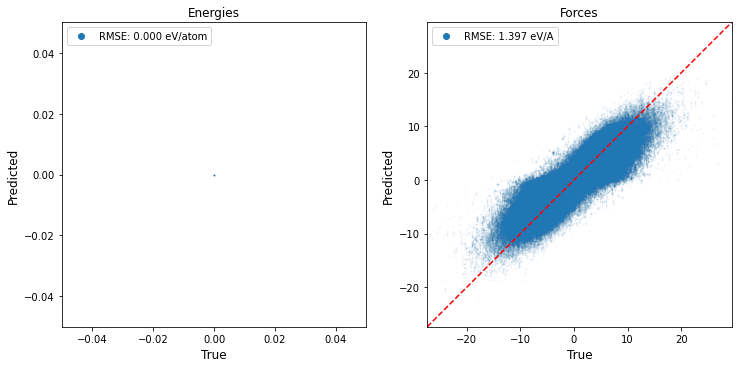

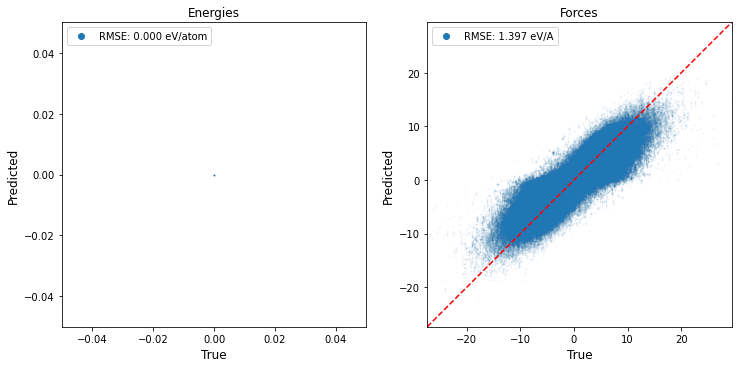

In [85]:
fcs_np = np.concatenate(epoch_fcs)
true_fcs_np = np.concatenate(epoch_true_fcs)
eng_np = np.zeros(1)
true_eng_np = np.zeros(1)

plot_pred_vs_true(
    eng_np,
    fcs_np,
    true_eng_np,
    true_fcs_np
)

In [80]:
2.199**2

4.835601

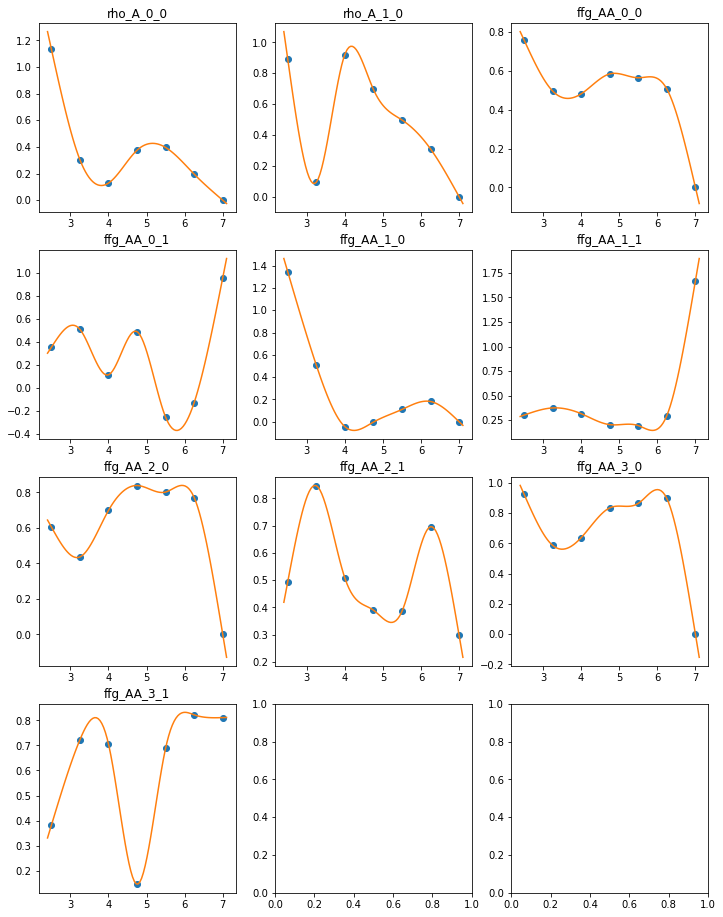

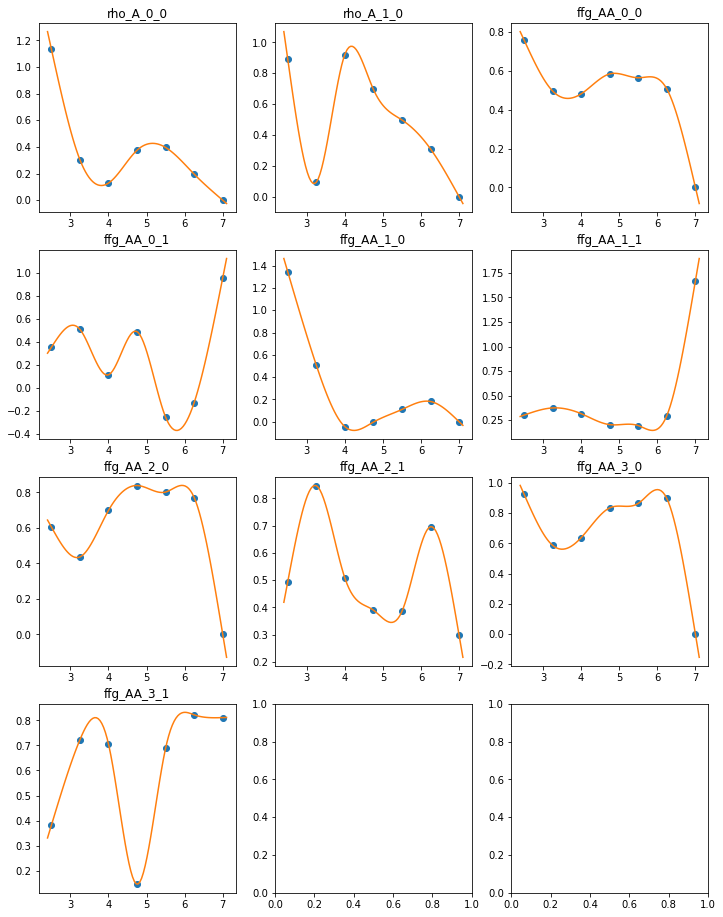

In [86]:
splitParams = []
names = []
for k in embedder.embeddings:
    for d in range(embedder.embeddings[k][2]):
        for i in range(len(embedder.embeddings[k][0])):
            s, n = embedder._fill(k, d, i)
            splitParams.append(np.array(s.cpu().detach()))
            names.append(n)
            
plot_splines(splitParams, names)